# В качестве проекта, возьмем датасет 'movie_metadata' с сайта kaggle.com. В данном датасете представлено 5043 записи о различных фильмах. Попробуем предсказать оценку фильма на IMDB.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor 
from sklearn.linear_model import BayesianRidge, ElasticNet, HuberRegressor, LinearRegression, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%pylab inline
from collections import Counter
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [77]:
movies_data = pd.read_csv('Movie_Resume\\movie_metadata.csv')
movies_data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


### Рассмотрим колонки в датасете

In [3]:
movies_data.columns

Index([u'color', u'director_name', u'num_critic_for_reviews', u'duration',
       u'director_facebook_likes', u'actor_3_facebook_likes', u'actor_2_name',
       u'actor_1_facebook_likes', u'gross', u'genres', u'actor_1_name',
       u'movie_title', u'num_voted_users', u'cast_total_facebook_likes',
       u'actor_3_name', u'facenumber_in_poster', u'plot_keywords',
       u'movie_imdb_link', u'num_user_for_reviews', u'language', u'country',
       u'content_rating', u'budget', u'title_year', u'actor_2_facebook_likes',
       u'imdb_score', u'aspect_ratio', u'movie_facebook_likes'],
      dtype='object')

### 1)'color' - цветное ли кино, возможные значения: NaN, 'Black and White', 'Color' 
### 2)'director_name' - режиссер данного фильма (может принимать значение NaN)
### 3)'num_critic_for_reviews' - количество критиков, оценивших фильм (может принимать значение NaN)
### 4)'duration' - продолжительность фильма (может принимать значение NaN)
### 5)'director_facebook_likes' - количество лайков на странице режиссера в facebook (может принимать значение NaN)
### 6)'actor_1_facebook_likes', 'actor_2_facebook_likes','actor_3_facebook_likes' - количество лайков на странице актеров фильма в facebook (может принимать значение NaN)
### 7)'actor_1_name', 'actor_2_name', 'actor_3_name' - актеры фильма (может принимать значение NaN)
### 8)'gross' - сборы фильма (может принимать значение NaN)
### 9)'genres' - в каких жанрах снят фильм
### 10)'movie_title' - название фильма
### 11)'num_voted_users' - количество проголосовавших пользователей 
### 12)'cast_total_facebook_likes' - общая сумма лайков на facebook у всей съемочной группы
### 13)'facenumber_in_poster' - количество людей на постере (может принимать значение NaN)
### 14)'plot_keywords' - теги, используемые для описания фильма (может принимать значение NaN)
### 15)'movie_imdb_link' - ссылка на фильм на IMDB
### 16)'num_user_for_reviews' - количество пользователей, написавших отзыв о фильме (может принимать значение NaN)
### 17)'language' - язык фильма (может принимать значение NaN)
### 18)'country' - страна-производитель фильма (может принимать значение NaN)
### 19)'content_rating' - рейтинг фильма (может принимать значение NaN)
### 20)'budget' - бюджет фильма (может принимать значение NaN)
### 21)'title_year' - год выхода фильма (может принимать значение NaN)
### 22)'aspect_ratio' - соотношение сторон в фильме (может принимать значение NaN)
### 23)'movie_facebook_likes' - количество лайков у фильма на facebook
### 24)'imdb_score' - оценка фильма на IMDB (целевая переменная)

### 1)Для начала разобьем данную выборку на тренировочную и тестовую.
### 2)Затем на основе исходных данных создадим собственные признаки
### 3)Решим задачу регрессии (прим. данная задача не подходит под задачу классификации в силу разнообразия оценок, а также целевая переменная несет количественный смысл, который теряется при классификации. Если прогнозируемая оценка меньше 0.0, то округляем ее до 0.0, аналогично поступаем, если оценка больше 10.0. В качестве оценки качества используем среднеквадратичную ошибку)

In [78]:
movie_train, movie_test = train_test_split(movies_data, test_size=0.15, random_state=42)

In [32]:
movie_train.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
4213,Color,Robby Henson,25.0,101.0,9.0,201.0,Max Ryan,973.0,978908.0,Drama|Horror|Mystery|Thriller,...,90.0,English,Poland,PG-13,2400000.0,2006.0,872.0,5.1,2.35,250
856,Color,Frank Oz,140.0,85.0,0.0,490.0,Adam Alexi-Malle,21000.0,66365290.0,Comedy,...,358.0,English,USA,PG-13,55000000.0,1999.0,860.0,6.4,1.37,0
1052,Color,James Mangold,295.0,122.0,446.0,600.0,Logan Lerman,23000.0,53574088.0,Adventure|Crime|Drama|Western,...,560.0,English,USA,R,55000000.0,2007.0,8000.0,7.8,2.35,0
2653,Color,Nicolas Winding Refn,676.0,100.0,0.0,228.0,Albert Brooks,33000.0,35054909.0,Crime|Drama,...,1264.0,English,USA,R,15000000.0,2011.0,745.0,7.8,2.35,81000
4573,Color,Mel Brooks,48.0,92.0,0.0,842.0,Sid Caesar,1000.0,NaN,Comedy,...,131.0,English,USA,R,11000000.0,1981.0,898.0,6.9,2.35,0


In [78]:
movie_train_data = pd.DataFrame()
movie_test_data = pd.DataFrame()

## Создание признаков

### Целевая переменная

In [82]:
def get_IMDB_score(data):
    return data.imdb_score.values
movie_train_data['imdb_score'] = get_IMDB_score(movie_train)
movie_test_data['imdb_score'] = get_IMDB_score(movie_test)
movie_train_data.to_csv('Movie_Resume\\movie_train_data.csv',sep=',',index=None,header=True)
movie_test_data.to_csv('Movie_Resume\\movie_test_data.csv',sep=',',index=None,header=True)  

### Цветной ли фильм

In [90]:
#В первоночальной выборке существуют фильмы, у которых не указано цветные ли они. 
#В этом случае ориентируемся на год создания фильма. Если фильм снят позже 2000ого года, считаем, что он цветной
def is_color(data):
    colors = data.color.values
    title_year = data.title_year.values
    is_color = []
    for i in range(len(colors)):
        if colors[i] == 'Color':
            is_color.append(1)
        if colors[i] == ' Black and White':
            is_color.append(0)
        if colors[i] != colors[i]:
            if title_year[i] >= 2000:
                is_color.append(1)
            else:
                is_color.append(0)
    return is_color
movie_train_data['is_color'] = is_color(movie_train)
movie_test_data['is_color'] = is_color(movie_test)
movie_train_data.to_csv('Movie_Resume\\movie_train_data.csv',sep=',',index=None,header=True)
movie_test_data.to_csv('Movie_Resume\\movie_test_data.csv',sep=',',index=None,header=True)

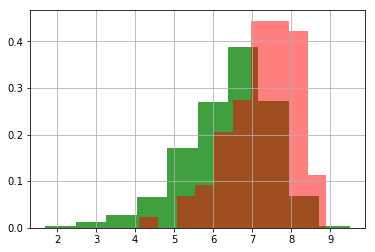

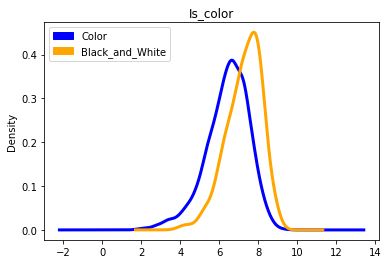

In [11]:
#Посмотрим на гистограммы оценок в зависимости от цвета фильма
movie_train_data[movie_train_data.is_color == 1].imdb_score.hist(normed=True,color='green',alpha=0.75)
movie_train_data[movie_train_data.is_color == 0].imdb_score.hist(normed=True,color='red',alpha=0.5)
plt.show()
#Плотности
plt.title('Is_color')
movie_train_data[movie_train_data.is_color == 1].imdb_score.plot(kind='kde',linewidth = 3,color = 'blue')
movie_train_data[movie_train_data.is_color == 0].imdb_score.plot(kind='kde',linewidth = 3,color = 'orange')

blue_patch = mpatches.Patch(color='blue',label='Color')
orange_patch = mpatches.Patch(color = 'orange',label='Black_and_White')
plt.legend(handles=[blue_patch,orange_patch])

In [101]:
print 'Цветной фильм:',movie_train_data[movie_train_data.is_color==1].imdb_score.mean()
print 'Черно-белый фильм:',movie_train_data[movie_train_data.is_color==0].imdb_score.mean()

Цветной фильм: 6.40853034365
Черно-белый фильм: 7.26284153005


#### По гистограммам и средней оценке фильма можно сделать вывод, что в среднем у черно-белых фильмов оценка выше

### Рассмотрим теперь признак genres
#### Для создания признаков на основе исходного будем использовать только тренировочную выборку, по-скольку возможен случай, когда жанр существует в тестовой выборке и не существует в тренировочной, это может повлиять на качество регрессора

In [171]:
def get_all_genres(data):
    genres = data.genres.values
    all_genres = []
    for i in range(len(genres)):
        all_genres.extend(genres[i].split('|'))
    return np.unique(all_genres)
def create_genres_features(data):
    all_genres = get_all_genres(movie_train)
    genres = data.genres.values
    genres_features = np.zeros((data.shape[0],len(all_genres)))
    for i in range(len(genres)):
        for j in range(len(all_genres)):
            if genres[i].count(all_genres[j]) != 0:
                genres_features[i][j] = 1
    return genres_features.transpose()
#Тренировочная выборка
genres_features = create_genres_features(movie_train)   
all_genres = get_all_genres(movie_train)
for i in range(len(genres_features)):
    movie_train_data['Genre_'+all_genres[i]] = genres_features[i]
#Тестовая выборка
genres_features = create_genres_features(movie_test)   
all_genres = get_all_genres(movie_train)
for i in range(len(genres_features)):
    movie_test_data['Genre_'+all_genres[i]] = genres_features[i]      
        

In [191]:
#Посмотрим на 3 самых популярных жанра
counts_of_genres = []
for i in movie_train_data.columns[2:]:
    counts_of_genres.append((i,movie_train_data[i].sum()))
counts_of_genres.sort(reverse=True, key = lambda x: x[1])
counts_of_genres[:3]

[('Genre_Drama', 2209.0), ('Genre_Comedy', 1604.0), ('Genre_Thriller', 1192.0)]

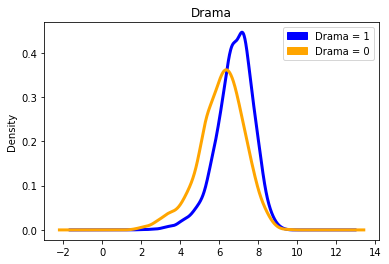

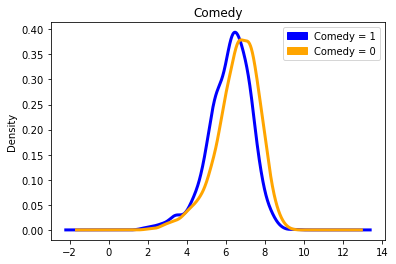

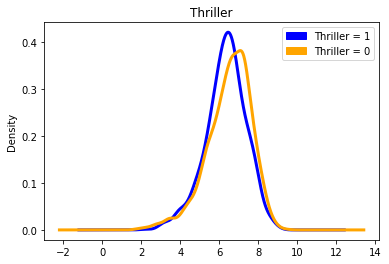

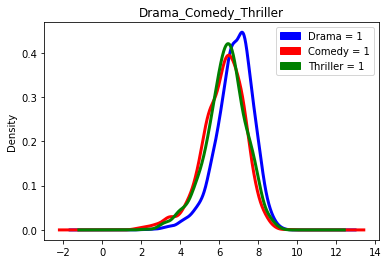

In [239]:
#Посмотрим на плотности оценок в зависимости от жанра фильма
plt.title('Drama')
movie_train_data[movie_train_data.Genre_Drama == 1].imdb_score.plot(kind='kde',linewidth = 3, color = 'blue')
movie_train_data[movie_train_data.Genre_Drama == 0].imdb_score.plot(kind='kde',linewidth = 3, color = 'orange')
blue_patch = mpatches.Patch(color='blue',label='Drama = 1')
orange_patch = mpatches.Patch(color = 'orange',label='Drama = 0')
plt.legend(handles=[blue_patch,orange_patch])
plt.show()

plt.title('Comedy')
movie_train_data[movie_train_data.Genre_Comedy == 1].imdb_score.plot(kind='kde',linewidth = 3, color = 'blue')
movie_train_data[movie_train_data.Genre_Comedy == 0].imdb_score.plot(kind='kde',linewidth = 3, color = 'orange')
blue_patch = mpatches.Patch(color='blue',label='Comedy = 1')
orange_patch = mpatches.Patch(color = 'orange',label='Comedy = 0')
plt.legend(handles=[blue_patch,orange_patch])
plt.show()

plt.title('Thriller')
movie_train_data[movie_train_data.Genre_Thriller == 1].imdb_score.plot(kind='kde',linewidth = 3, color = 'blue')
movie_train_data[movie_train_data.Genre_Thriller == 0].imdb_score.plot(kind='kde',linewidth = 3, color = 'orange')
blue_patch = mpatches.Patch(color='blue',label='Thriller = 1')
orange_patch = mpatches.Patch(color = 'orange',label='Thriller = 0')
plt.legend(handles=[blue_patch,orange_patch])
plt.show()

plt.title('Drama_Comedy_Thriller')
movie_train_data[movie_train_data.Genre_Drama == 1].imdb_score.plot(kind='kde',linewidth = 3, color = 'blue')
movie_train_data[movie_train_data.Genre_Comedy == 1].imdb_score.plot(kind='kde',linewidth = 3, color = 'red')
movie_train_data[movie_train_data.Genre_Thriller == 1].imdb_score.plot(kind='kde',linewidth = 3, color = 'green')
blue_patch = mpatches.Patch(color='blue',label='Drama = 1')
red_patch = mpatches.Patch(color = 'red',label='Comedy = 1')
green_patch = mpatches.Patch(color = 'green',label='Thriller = 1')
plt.legend(handles=[blue_patch,red_patch,green_patch])
plt.show()

In [241]:
print 'Драма:',movie_train_data[movie_train_data.Genre_Drama==1].imdb_score.mean()
print 'Комедия:',movie_train_data[movie_train_data.Genre_Comedy==1].imdb_score.mean()
print 'Триллер:',movie_train_data[movie_train_data.Genre_Thriller==1].imdb_score.mean()

Драма: 6.76962426437
Комедия: 6.19451371571
Триллер: 6.32256711409


In [245]:
imdb_and_genres = []
for i in movie_train_data.columns[2:]:
    imdb_and_genres.append((i,movie_train_data[movie_train_data[i] == 1].imdb_score.mean()))
imdb_and_genres.sort(reverse=True, key = lambda x: x[1])
imdb_and_genres[:3]

[('Genre_Film-Noir', 7.633333333333333),
 ('Genre_News', 7.533333333333334),
 ('Genre_Documentary', 7.197087378640775)]

### Среди трех самых популярных жанров самым удачным является драма. Среди всех представленных жанров самый удачный жанр - это жанр Нуар

### Теперь давайте разберемся с такими признаками как страна-производитель и язык (country, language)

In [252]:
print 'Countries:', np.unique(movie_train.country)
print 'Languages:',np.unique(movie_train.language)

Countries: [nan nan nan 'Afghanistan' 'Argentina' 'Aruba' 'Australia' 'Bahamas'
 'Belgium' 'Brazil' 'Cambodia' 'Cameroon' 'Canada' 'Chile' 'China'
 'Colombia' 'Czech Republic' 'Denmark' 'Egypt' 'Finland' 'France' 'Georgia'
 'Germany' 'Greece' 'Hong Kong' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iran' 'Ireland' 'Israel' 'Italy' 'Japan' 'Kenya' 'Kyrgyzstan' 'Libya'
 'Mexico' 'Netherlands' 'New Line' 'New Zealand' 'Norway' 'Official site'
 'Pakistan' 'Panama' 'Peru' 'Philippines' 'Poland' 'Romania' 'Russia'
 'Slovakia' 'Slovenia' 'South Africa' 'South Korea' 'Soviet Union' 'Spain'
 'Sweden' 'Switzerland' 'Taiwan' 'Thailand' 'Turkey' 'UK' 'USA'
 'United Arab Emirates' 'West Germany']
Languages: [nan nan nan nan nan nan nan nan nan nan 'Aboriginal' 'Arabic' 'Aramaic'
 'Bosnian' 'Cantonese' 'Chinese' 'Czech' 'Danish' 'Dari' 'Dutch' 'English'
 'French' 'German' 'Greek' 'Hebrew' 'Hindi' 'Hungarian' 'Icelandic'
 'Indonesian' 'Italian' 'Japanese' 'Kannada' 'Kazakh' 'Korean' 'Mandarin'
 'Maya' '

### Разобьем страну-производитель на несколько классов: USA, Europe, India, Asia, Other. Россию отнесем к европейскому кино.

In [289]:
# Определим страну-производитель фильма
def get_country_region(data):
    country_regions = [['USA'],
                 ['India'],
                 ['Belgium','Czech Republic','Denmark','Finland','France',
                  'Germany','Greece','Hungary','Iceland','Ireland','Italy',
                  'Netherlands','Norway','Poland','Romania','Russia','Slovakia',
                  'Slovenia','Spain','Sweden','Switzerland','Turkey','UK','West Germany'],
                 ['China','Hong Kong','Indonesia','Japan','South Korea','Taiwan','Thailand']]
    countries = data.country.values
    country_features = np.zeros((data.shape[0],5))
    for i in range(len(countries)):
        for j in range(len(country_regions)):
            if country_regions[j].count(countries[i]) != 0:
                country_features[i][j] = 1
                continue
        if sum(country_features[i]) == 0:
            country_features[i][4] = 1
    return country_features.transpose()
regions = ['USA','India','Europe','Asia','Other']
country_features = get_country_region(movie_train)
for i in range(len(country_features)):
    movie_train_data['Region_'+regions[i]] = country_features[i]

country_features = get_country_region(movie_test)
for i in range(len(country_features)):
    movie_test_data['Region_'+regions[i]] = country_features[i]
movie_train_data.to_csv('Movie_Resume\\movie_train_data.csv',sep=',',index=None,header=True)
movie_test_data.to_csv('Movie_Resume\\movie_test_data.csv',sep=',',index=None,header=True)

### Давайте оценим средние оценки в зависимости от региона

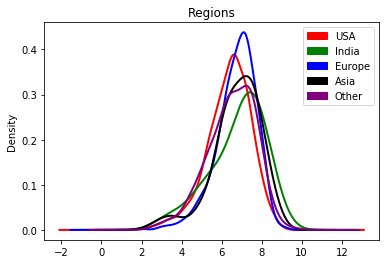

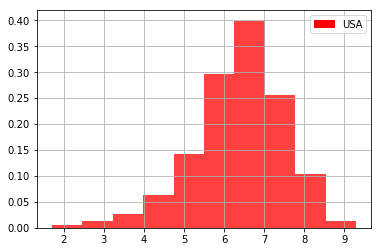

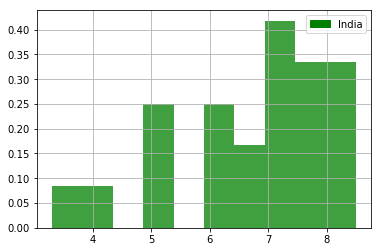

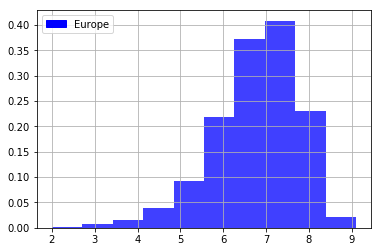

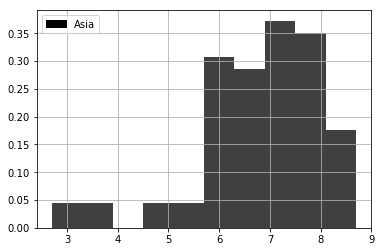

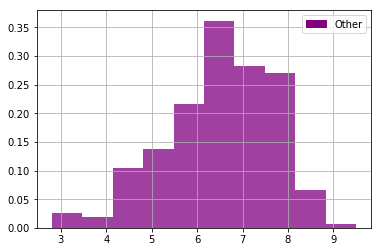

Mean imdb_score for Region_USA: 6.36594627972
Mean imdb_score for Region_India: 6.77391304348
Mean imdb_score for Region_Europe: 6.74036061026
Mean imdb_score for Region_Asia: 6.74473684211
Mean imdb_score for Region_Other: 6.5013215859


In [320]:
colors = ['red','green','blue','black','purple']
red_patch = mpatches.Patch(color = 'red',label='USA')
green_patch = mpatches.Patch(color = 'green',label='India')
blue_patch = mpatches.Patch(color='blue',label='Europe')
black_patch = mpatches.Patch(color='black',label='Asia')
purple_patch = mpatches.Patch(color='purple',label='Other')
patches = [red_patch,green_patch,blue_patch,black_patch,purple_patch]
#Плотности распределений
for i in range(len(country_features)):
    movie_train_data[movie_train_data['Region_'+regions[i]] == 1].imdb_score.plot(kind='kde',linewidth = 2,color=colors[i])
plt.legend(handles=patches)
plt.title('Regions')
plt.show()
#Гистограммы распределений
for i in range(len(country_features)):
    movie_train_data[movie_train_data['Region_'+regions[i]] == 1].imdb_score.hist(normed=True,alpha=0.75,color=colors[i])
    plt.legend(handles=[patches[i]])
    plt.show()
for i in range(len(country_features)):
    print 'Mean imdb_score for Region_'+regions[i]+':',movie_train_data[movie_train_data['Region_'+regions[i]] == 1].imdb_score.mean()

### Средние оценки примерно равны, отличие между худшей и лучшей составляет примерно 0.3. Интересно также то, что индийские фильмы в почете.

### Теперь рассмотрим язык фильма

In [315]:
print 'Фильмов на английском языке в тренировочной выборке:',Counter(movie_train.language)['English']
print 'Всего фильмов в тренировочной выборке:', movie_train.shape[0]

Фильмов на английском языке в тренировочной выборке: 4001
Всего фильмов в тренировочной выборке: 4286


### Количество фильмов на английском языке составляет около 90%. Соответственно создадим признак: язык фильма - английский 

In [317]:
def is_english(data):
    languages = data.language.values
    is_english = []
    for i in range(len(languages)):
        if languages[i] == 'English':
            is_english.append(1)
        else:
            is_english.append(0)
    return is_english
movie_train_data['is_english'] = is_english(movie_train)
movie_test_data['is_english'] = is_english(movie_test)
movie_train_data.to_csv('Movie_Resume\\movie_train_data.csv',sep=',',index=None,header=True)
movie_test_data.to_csv('Movie_Resume\\movie_test_data.csv',sep=',',index=None,header=True)

### Давайте оценим средние оценки в зависимости от языка

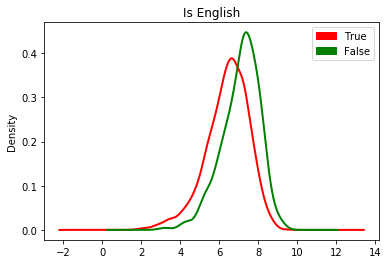

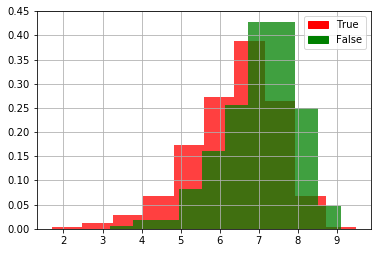

Mean imdb_score for is_english = True: 6.39937515621
Mean imdb_score for is_english = False: 7.08561403509


In [323]:
colors = ['red','green']
red_patch = mpatches.Patch(color = 'red',label='True')
green_patch = mpatches.Patch(color = 'green',label='False')
patches = [red_patch,green_patch]
#Плотности распределений
movie_train_data[movie_train_data['is_english'] == 1].imdb_score.plot(kind='kde',linewidth = 2,color=colors[0])
movie_train_data[movie_train_data['is_english'] == 0].imdb_score.plot(kind='kde',linewidth = 2,color=colors[1])
plt.legend(handles=patches)
plt.title('Is English')
plt.show()
#Гистограммы распределений
movie_train_data[movie_train_data['is_english'] == 1].imdb_score.hist(normed=True,alpha=0.75,color=colors[0])
movie_train_data[movie_train_data['is_english'] == 0].imdb_score.hist(normed=True,alpha=0.75,color=colors[1])
plt.legend(handles=patches)
plt.show()

print 'Mean imdb_score for is_english = True:',movie_train_data[movie_train_data['is_english'] == 1].imdb_score.mean()
print 'Mean imdb_score for is_english = False:',movie_train_data[movie_train_data['is_english'] == 0].imdb_score.mean()

### Интересно, что фильмы, не использующие английский язык имеют оценку выше. Возможно это связано с несбалансированностью выборки, также не факт, что "плохие неанглийские" фильмы просто не представлены на IMDB.

### Теперь давайте введем признаки связанные с актерами: сколько актеров, у которых большая фильмография, снимаются в фильме, сколько актеров, у которых средняя оценка фильма, высокаяснимается в фильме, сколько актеров, которых большое количество лайков на facebook, снимаются в фильме.

#### По-скольку выборка ограниченная, давайте считать, что у актера большая фильмография, если он снялся в 8 фильмах и больше

In [358]:
def get_actors_with_big_filmography(data):
    actors_1_name = list(data.actor_1_name.values)
    actors_2_name = list(data.actor_2_name.values)
    actors_3_name = list(data.actor_3_name.values)
    
    actors = list(movie_train.actor_1_name.values)
    actors.extend(list(movie_train.actor_2_name.values))
    actors.extend(list(movie_train.actor_3_name.values))
    
    dict_of_actors = Counter(actors)
    count_of_actors_with_big_filmography = []
    for i in range(len(actors_1_name)):
        count_of_actors_with_big_filmography.append(0)

        if (dict_of_actors[actors_1_name[i]] >= 8) & (actors_1_name[i] == actors_1_name[i]): #<- проверка на nan
            count_of_actors_with_big_filmography[i] += 1
        if (dict_of_actors[actors_2_name[i]] >= 8) & (actors_2_name[i] == actors_2_name[i]):
            count_of_actors_with_big_filmography[i] += 1
        if (dict_of_actors[actors_3_name[i]] >= 8) & (actors_3_name[i] == actors_3_name[i]):
            count_of_actors_with_big_filmography[i] += 1
        
    return count_of_actors_with_big_filmography


movie_train_data['count_of_actors_with_big_filmography'] = get_actors_with_big_filmography(movie_train)
movie_test_data['count_of_actors_with_big_filmography'] = get_actors_with_big_filmography(movie_test)
movie_train_data.to_csv('Movie_Resume\\movie_train_data.csv',sep=',',index=None,header=True)
movie_test_data.to_csv('Movie_Resume\\movie_test_data.csv',sep=',',index=None,header=True)

### Теперь посмотрим на значение оценки на imdb в зависиомсти от значения признака

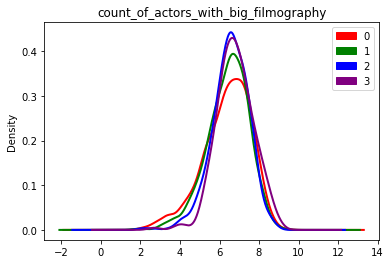

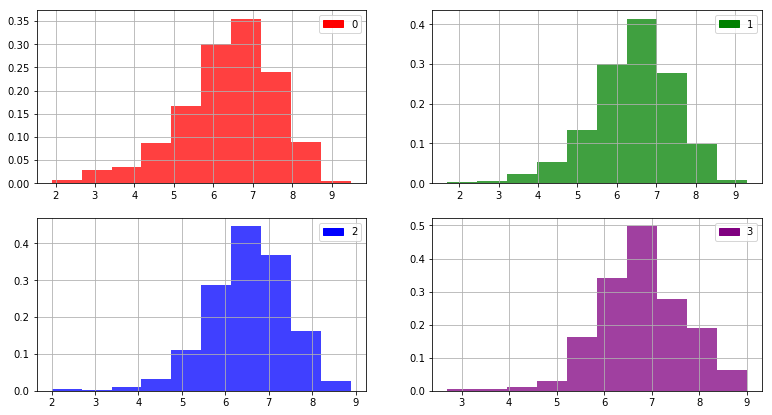

Mean imdb_score for count_of_actors_with_big_filmography = 0: 6.38040573973
Mean imdb_score for count_of_actors_with_big_filmography = 1: 6.41902897416
Mean imdb_score for count_of_actors_with_big_filmography = 2: 6.54481792717
Mean imdb_score for count_of_actors_with_big_filmography = 3: 6.78248175182


In [382]:
colors = ['red','green','blue','purple']
red_patch = mpatches.Patch(color = 'red',label='0')
green_patch = mpatches.Patch(color = 'green',label='1')
blue_patch = mpatches.Patch(color = 'blue',label='2')
purple_patch = mpatches.Patch(color = 'purple',label='3')
patches = [red_patch,green_patch,blue_patch,purple_patch]
#Плотности распределений
movie_train_data[movie_train_data['count_of_actors_with_big_filmography'] == 0].imdb_score.plot(kind='kde',linewidth = 2,color=colors[0])
movie_train_data[movie_train_data['count_of_actors_with_big_filmography'] == 1].imdb_score.plot(kind='kde',linewidth = 2,color=colors[1])
movie_train_data[movie_train_data['count_of_actors_with_big_filmography'] == 2].imdb_score.plot(kind='kde',linewidth = 2,color=colors[2])
movie_train_data[movie_train_data['count_of_actors_with_big_filmography'] == 3].imdb_score.plot(kind='kde',linewidth = 2,color=colors[3])
plt.legend(handles=patches)
plt.title('count_of_actors_with_big_filmography')
plt.show()
#Гистограммы распределений (гистограммы накладываются друг на друга, сделаем их отдельно)
plt.figure(figsize=(13,7))
plt.subplot(221)
movie_train_data[movie_train_data['count_of_actors_with_big_filmography'] == 0].imdb_score.hist(normed=True,alpha=0.75,color=colors[0])
plt.legend(handles=[patches[0]])
plt.subplot(222)
movie_train_data[movie_train_data['count_of_actors_with_big_filmography'] == 1].imdb_score.hist(normed=True,alpha=0.75,color=colors[1])
plt.legend(handles=[patches[1]])
plt.subplot(223)
movie_train_data[movie_train_data['count_of_actors_with_big_filmography'] == 2].imdb_score.hist(normed=True,alpha=0.75,color=colors[2])
plt.legend(handles=[patches[2]])
plt.subplot(224)
movie_train_data[movie_train_data['count_of_actors_with_big_filmography'] == 3].imdb_score.hist(normed=True,alpha=0.75,color=colors[3])
plt.legend(handles=[patches[3]])
plt.show()

print 'Mean imdb_score for count_of_actors_with_big_filmography = 0:',movie_train_data[movie_train_data['count_of_actors_with_big_filmography'] == 0].imdb_score.mean()
print 'Mean imdb_score for count_of_actors_with_big_filmography = 1:',movie_train_data[movie_train_data['count_of_actors_with_big_filmography'] == 1].imdb_score.mean()
print 'Mean imdb_score for count_of_actors_with_big_filmography = 2:',movie_train_data[movie_train_data['count_of_actors_with_big_filmography'] == 2].imdb_score.mean()
print 'Mean imdb_score for count_of_actors_with_big_filmography = 3:',movie_train_data[movie_train_data['count_of_actors_with_big_filmography'] == 3].imdb_score.mean()


#### Судя по графикам плотностей, а также гистограммам, можно сказать, что данные распределения похожи. Также разница между средними оценками равна 0.3

### Теперь рассмотрим признак: количество актеров с успешными фильмами, снявшихся в данном фильме. Но что считать успешным фильмом исходя из оценки imdb? Будем считать, что фильм с участием актера успешный, если его оценка выше средней оценки по всей выборки.

In [401]:
def get_actors_with_good_filmography(data):
    actors_1_name = list(data.actor_1_name.values)
    actors_2_name = list(data.actor_2_name.values)
    actors_3_name = list(data.actor_3_name.values)
    
    mean_score = movie_train.imdb_score.mean()
    
    actors = list(movie_train.actor_1_name.values)
    actors.extend(list(movie_train.actor_2_name.values))
    actors.extend(list(movie_train.actor_3_name.values))
    actors = list(np.unique(actors))
    actors_with_good_filmography = []
    mean_score_of_actors = []
    for i in range(len(actors)):
        mean_score_of_actors.append([])
        if movie_train[movie_train.actor_1_name == actors[i]].imdb_score.mean() == movie_train[movie_train.actor_1_name == actors[i]].imdb_score.mean():
            mean_score_of_actors[i].append(movie_train[movie_train.actor_1_name == actors[i]].imdb_score.mean())
        if movie_train[movie_train.actor_2_name == actors[i]].imdb_score.mean() == movie_train[movie_train.actor_2_name == actors[i]].imdb_score.mean():
            mean_score_of_actors[i].append(movie_train[movie_train.actor_2_name == actors[i]].imdb_score.mean())
        if movie_train[movie_train.actor_3_name == actors[i]].imdb_score.mean() == movie_train[movie_train.actor_3_name == actors[i]].imdb_score.mean():
            mean_score_of_actors[i].append(movie_train[movie_train.actor_3_name == actors[i]].imdb_score.mean())
        mean_score_of_actors[i] = sum(mean_score_of_actors[i]) / len(mean_score_of_actors[i])
    
    for i in range(len(actors_1_name)):
        actors_with_good_filmography.append(0.0)
        if actors_1_name[i] == actors_1_name[i]: # <- проверка на nan
            if actors.count(actors_1_name[i]) > 0: # <- проверка если этот актер в тренировочной выборке
                if mean_score_of_actors[actors.index(actors_1_name[i])] >= mean_score:
                    actors_with_good_filmography[i] += 1
        if actors_2_name[i] == actors_2_name[i]:
            if actors.count(actors_2_name[i]) > 0:
                if mean_score_of_actors[actors.index(actors_2_name[i])] >= mean_score:
                    actors_with_good_filmography[i] += 1
        if actors_3_name[i] == actors_3_name[i]:
            if actors.count(actors_3_name[i]) > 0:
                if mean_score_of_actors[actors.index(actors_3_name[i])] >= mean_score:
                    actors_with_good_filmography[i] += 1
    
    return actors_with_good_filmography

movie_train_data['count_of_actors_with_good_filmography'] = get_actors_with_good_filmography(movie_train)
movie_test_data['count_of_actors_with_good_filmography'] = get_actors_with_good_filmography(movie_test)
movie_train_data.to_csv('Movie_Resume\\movie_train_data.csv',sep=',',index=None,header=True)
movie_test_data.to_csv('Movie_Resume\\movie_test_data.csv',sep=',',index=None,header=True)

C:\Users\EasyKiska\Anaconda2\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


### Теперь посмотрим на значение оценки на imdb в зависиомсти от значения признака

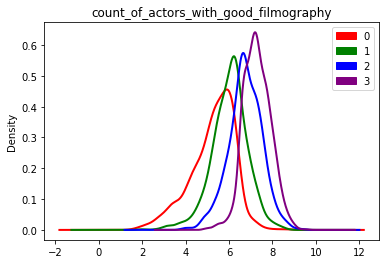

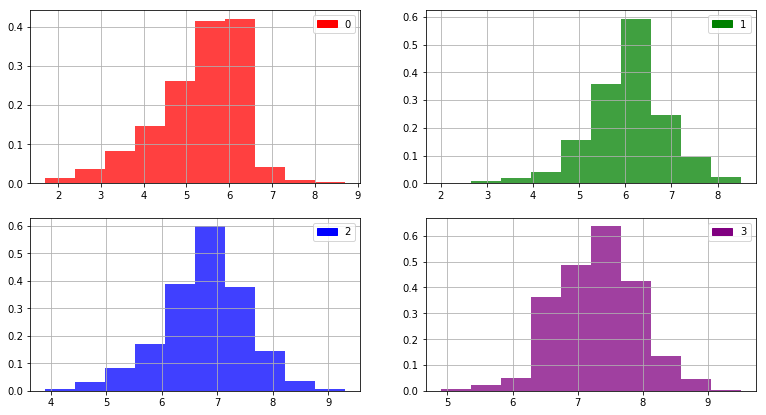

Mean imdb_score for count_of_actors_with_good_filmography = 0: 5.26
Mean imdb_score for count_of_actors_with_good_filmography = 1: 6.02497249725
Mean imdb_score for count_of_actors_with_good_filmography = 2: 6.74647177419
Mean imdb_score for count_of_actors_with_good_filmography = 3: 7.28717770035


In [404]:
colors = ['red','green','blue','purple']
red_patch = mpatches.Patch(color = 'red',label='0')
green_patch = mpatches.Patch(color = 'green',label='1')
blue_patch = mpatches.Patch(color = 'blue',label='2')
purple_patch = mpatches.Patch(color = 'purple',label='3')
patches = [red_patch,green_patch,blue_patch,purple_patch]
#Плотности распределений
movie_train_data[movie_train_data['count_of_actors_with_good_filmography'] == 0].imdb_score.plot(kind='kde',linewidth = 2,color=colors[0])
movie_train_data[movie_train_data['count_of_actors_with_good_filmography'] == 1].imdb_score.plot(kind='kde',linewidth = 2,color=colors[1])
movie_train_data[movie_train_data['count_of_actors_with_good_filmography'] == 2].imdb_score.plot(kind='kde',linewidth = 2,color=colors[2])
movie_train_data[movie_train_data['count_of_actors_with_good_filmography'] == 3].imdb_score.plot(kind='kde',linewidth = 2,color=colors[3])
plt.legend(handles=patches)
plt.title('count_of_actors_with_good_filmography')
plt.show()
#Гистограммы распределений (гистограммы накладываются друг на друга, сделаем их отдельно)
plt.figure(figsize=(13,7))
plt.subplot(221)
movie_train_data[movie_train_data['count_of_actors_with_good_filmography'] == 0].imdb_score.hist(normed=True,alpha=0.75,color=colors[0])
plt.legend(handles=[patches[0]])
plt.subplot(222)
movie_train_data[movie_train_data['count_of_actors_with_good_filmography'] == 1].imdb_score.hist(normed=True,alpha=0.75,color=colors[1])
plt.legend(handles=[patches[1]])
plt.subplot(223)
movie_train_data[movie_train_data['count_of_actors_with_good_filmography'] == 2].imdb_score.hist(normed=True,alpha=0.75,color=colors[2])
plt.legend(handles=[patches[2]])
plt.subplot(224)
movie_train_data[movie_train_data['count_of_actors_with_good_filmography'] == 3].imdb_score.hist(normed=True,alpha=0.75,color=colors[3])
plt.legend(handles=[patches[3]])
plt.show()

print 'Mean imdb_score for count_of_actors_with_good_filmography = 0:',movie_train_data[movie_train_data['count_of_actors_with_good_filmography'] == 0].imdb_score.mean()
print 'Mean imdb_score for count_of_actors_with_good_filmography = 1:',movie_train_data[movie_train_data['count_of_actors_with_good_filmography'] == 1].imdb_score.mean()
print 'Mean imdb_score for count_of_actors_with_good_filmography = 2:',movie_train_data[movie_train_data['count_of_actors_with_good_filmography'] == 2].imdb_score.mean()
print 'Mean imdb_score for count_of_actors_with_good_filmography = 3:',movie_train_data[movie_train_data['count_of_actors_with_good_filmography'] == 3].imdb_score.mean()


#### А вот здесь результаты интереснее! Чем больше актеров с хорошей фильмографией, тем выше оценка фильма. Разница составляет примерно 2.02!

### Давайте рассмотрим признак популярности актеров, снимающихся в фильме. Будем считать актера популярным, если на facebook  у него лайков больше 10000

In [424]:
def get_popular_actors(data):
    actors_1_name = list(data.actor_1_name.values)
    actors_2_name = list(data.actor_2_name.values)
    actors_3_name = list(data.actor_3_name.values)
    count_of_populars_actors = []
    for i in range(len(actors_1_name)):
        count_of_populars_actors.append(0.0)
        if actors_1_name[i] == actors_1_name[i]: # <- проверка на nan
            if data[data.actor_1_name == actors_1_name[i]].actor_1_facebook_likes.values[0] >= 10000:
                count_of_populars_actors[i] += 1
        if actors_2_name[i] == actors_2_name[i]:
            if data[data.actor_2_name == actors_2_name[i]].actor_2_facebook_likes.values[0] >= 10000:
                count_of_populars_actors[i] += 1
        if actors_3_name[i] == actors_3_name[i]:
            if data[data.actor_3_name == actors_3_name[i]].actor_3_facebook_likes.values[0] >= 10000:
                count_of_populars_actors[i] += 1
    return count_of_populars_actors
movie_train_data['count_of_populars_actors'] = get_popular_actors(movie_train)
movie_test_data['count_of_populars_actors'] = get_popular_actors(movie_test)
movie_train_data.to_csv('Movie_Resume\\movie_train_data.csv',sep=',',index=None,header=True)
movie_test_data.to_csv('Movie_Resume\\movie_test_data.csv',sep=',',index=None,header=True)

### Теперь посмотрим на значение оценки на imdb в зависиомсти от значения признака

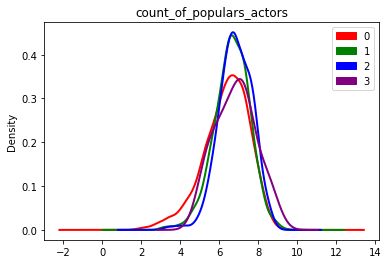

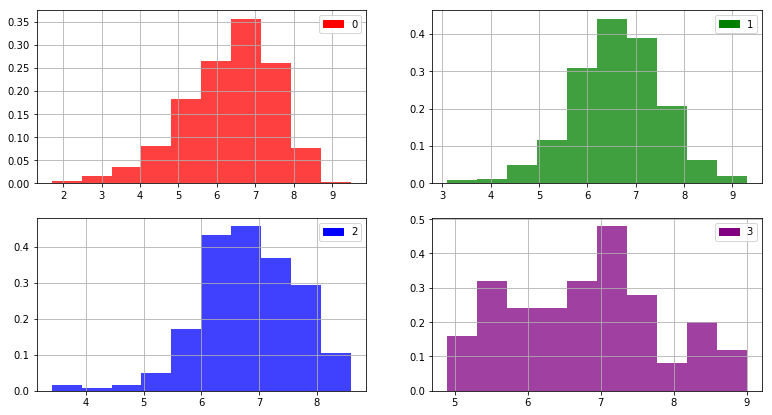

Mean imdb_score for count_of_populars_actors = 0: 6.34618952949
Mean imdb_score for count_of_populars_actors = 1: 6.63672839506
Mean imdb_score for count_of_populars_actors = 2: 6.82340425532
Mean imdb_score for count_of_populars_actors = 3: 6.82131147541


In [425]:
colors = ['red','green','blue','purple']
red_patch = mpatches.Patch(color = 'red',label='0')
green_patch = mpatches.Patch(color = 'green',label='1')
blue_patch = mpatches.Patch(color = 'blue',label='2')
purple_patch = mpatches.Patch(color = 'purple',label='3')
patches = [red_patch,green_patch,blue_patch,purple_patch]
#Плотности распределений
movie_train_data[movie_train_data['count_of_populars_actors'] == 0].imdb_score.plot(kind='kde',linewidth = 2,color=colors[0])
movie_train_data[movie_train_data['count_of_populars_actors'] == 1].imdb_score.plot(kind='kde',linewidth = 2,color=colors[1])
movie_train_data[movie_train_data['count_of_populars_actors'] == 2].imdb_score.plot(kind='kde',linewidth = 2,color=colors[2])
movie_train_data[movie_train_data['count_of_populars_actors'] == 3].imdb_score.plot(kind='kde',linewidth = 2,color=colors[3])
plt.legend(handles=patches)
plt.title('count_of_populars_actors')
plt.show()
#Гистограммы распределений (гистограммы накладываются друг на друга, сделаем их отдельно)
plt.figure(figsize=(13,7))
plt.subplot(221)
movie_train_data[movie_train_data['count_of_populars_actors'] == 0].imdb_score.hist(normed=True,alpha=0.75,color=colors[0])
plt.legend(handles=[patches[0]])
plt.subplot(222)
movie_train_data[movie_train_data['count_of_populars_actors'] == 1].imdb_score.hist(normed=True,alpha=0.75,color=colors[1])
plt.legend(handles=[patches[1]])
plt.subplot(223)
movie_train_data[movie_train_data['count_of_populars_actors'] == 2].imdb_score.hist(normed=True,alpha=0.75,color=colors[2])
plt.legend(handles=[patches[2]])
plt.subplot(224)
movie_train_data[movie_train_data['count_of_populars_actors'] == 3].imdb_score.hist(normed=True,alpha=0.75,color=colors[3])
plt.legend(handles=[patches[3]])
plt.show()

print 'Mean imdb_score for count_of_populars_actors = 0:',movie_train_data[movie_train_data['count_of_populars_actors'] == 0].imdb_score.mean()
print 'Mean imdb_score for count_of_populars_actors = 1:',movie_train_data[movie_train_data['count_of_populars_actors'] == 1].imdb_score.mean()
print 'Mean imdb_score for count_of_populars_actors = 2:',movie_train_data[movie_train_data['count_of_populars_actors'] == 2].imdb_score.mean()
print 'Mean imdb_score for count_of_populars_actors = 3:',movie_train_data[movie_train_data['count_of_populars_actors'] == 3].imdb_score.mean()


#### Разница около 0.5. Также интересен тот факт, что при наличии 3 популярных актеров распределение оценки фильма не такое ярко выраженное, как для случаев с 0, 1, 2 актерами.

### Аналогичные признаки сделаем и для режиссеров фильмов

### Будем считать, что режиссер имеет опыт, если снял 10 фильмов и больше из тренировочной выборки

In [441]:
def is_skilled_director(data):
    is_skilled = []
    directors = data.director_name.values
    dict_of_directors = Counter(movie_train.director_name)
    for i in range(len(directors)):
        is_skilled.append(0)
        if directors[i] == directors[i]: # <- проверка на nan
            if dict_of_directors[directors[i]] >= 10:
                is_skilled[i] = 1
    return is_skilled
movie_train_data['is_skilled_director'] = is_skilled_director(movie_train)
movie_test_data['is_skilled_director'] = is_skilled_director(movie_test)
movie_train_data.to_csv('Movie_Resume\\movie_train_data.csv',sep=',',index=None,header=True)
movie_test_data.to_csv('Movie_Resume\\movie_test_data.csv',sep=',',index=None,header=True)    

### Теперь посмотрим на значение оценки на imdb в зависиомсти от значения признака

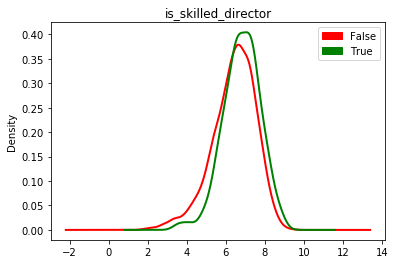

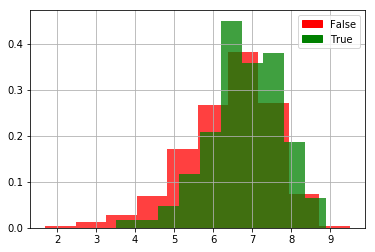

Mean imdb_score for is_skilled_director = False: 6.41294087795
Mean imdb_score for is_skilled_director = True: 6.81130434783


In [454]:
colors = ['red','green']
red_patch = mpatches.Patch(color = 'red',label='False')
green_patch = mpatches.Patch(color = 'green',label='True')
patches = [red_patch,green_patch]
#Плотности распределений
movie_train_data[movie_train_data['is_skilled_director'] == 0].imdb_score.plot(kind='kde',linewidth = 2,color=colors[0])
movie_train_data[movie_train_data['is_skilled_director'] == 1].imdb_score.plot(kind='kde',linewidth = 2,color=colors[1])
plt.legend(handles=patches)
plt.title('is_skilled_director')
plt.show()
#Гистограммы распределений 
movie_train_data[movie_train_data['is_skilled_director'] == 0].imdb_score.hist(normed=True,alpha=0.75,color=colors[0])
movie_train_data[movie_train_data['is_skilled_director'] == 1].imdb_score.hist(normed=True,alpha=0.75,color=colors[1])
plt.legend(handles=patches)
plt.show()

print 'Mean imdb_score for is_skilled_director = False:',movie_train_data[movie_train_data['is_skilled_director'] == 0].imdb_score.mean()
print 'Mean imdb_score for is_skilled_director = True:',movie_train_data[movie_train_data['is_skilled_director'] == 1].imdb_score.mean()


#### Разница всего в 0.4. Интересно, что распределение оценок с неопытным режиссером более выражено

### Теперь введем признак того, является ли режиссер успешным. Успешным будем считать режиссера, если средняя оценка его фильмов выше средней оценки по всей тренировочной выборке.

In [449]:
def is_successful_director(data):
    is_successful = []
    directors = data.director_name.values
    mean_score = movie_train.imdb_score.mean() 
    for i in range(len(directors)):
        is_successful.append(0)
        if directors[i] == directors[i]: # <- проверка на nan
            if data[data.director_name == directors[i]].imdb_score.mean() >= mean_score:
                is_successful[i] = 1
    return is_successful
movie_train_data['is_successful_director'] = is_successful_director(movie_train)
movie_test_data['is_successful_director'] = is_successful_director(movie_test)
movie_train_data.to_csv('Movie_Resume\\movie_train_data.csv',sep=',',index=None,header=True)
movie_test_data.to_csv('Movie_Resume\\movie_test_data.csv',sep=',',index=None,header=True)   

### Теперь посмотрим на значение оценки на imdb в зависиомсти от значения признака

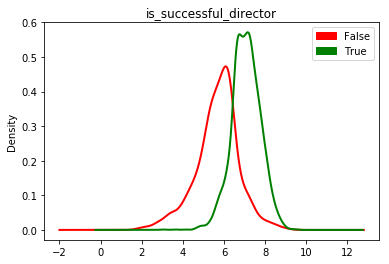

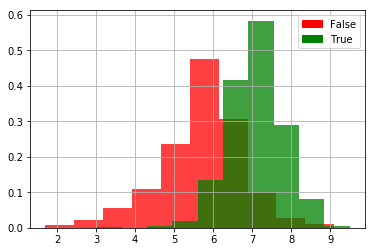

Mean imdb_score for is_successful_director = False: 5.685
Mean imdb_score for is_successful_director = True: 7.07348678602


In [453]:
colors = ['red','green']
red_patch = mpatches.Patch(color = 'red',label='False')
green_patch = mpatches.Patch(color = 'green',label='True')
patches = [red_patch,green_patch]
#Плотности распределений
movie_train_data[movie_train_data['is_successful_director'] == 0].imdb_score.plot(kind='kde',linewidth = 2,color=colors[0])
movie_train_data[movie_train_data['is_successful_director'] == 1].imdb_score.plot(kind='kde',linewidth = 2,color=colors[1])
plt.legend(handles=patches)
plt.title('is_successful_director')
plt.show()
#Гистограммы распределений
movie_train_data[movie_train_data['is_successful_director'] == 0].imdb_score.hist(normed=True,alpha=0.75,color=colors[0])
movie_train_data[movie_train_data['is_successful_director'] == 1].imdb_score.hist(normed=True,alpha=0.75,color=colors[1])
plt.legend(handles=patches)
plt.show()


print 'Mean imdb_score for is_successful_director = False:',movie_train_data[movie_train_data['is_successful_director'] == 0].imdb_score.mean()
print 'Mean imdb_score for is_successful_director = True:',movie_train_data[movie_train_data['is_successful_director'] == 1].imdb_score.mean()


#### Как и ожидалось, если у фильма успешный режиссер, то и оценка его, как правило выше.

### Теперь давайте рассмотрим такой признак, как возрастной рейтинг фильма

In [462]:
# Рейтинги, представленные в выборке
# Предлагаю Выбрать 4 рейтинга: PG, PG-13, R, other
Counter(movie_train.content_rating)

Counter({nan: 250,
         'Approved': 46,
         'G': 89,
         'GP': 6,
         'M': 5,
         'NC-17': 6,
         'Not Rated': 94,
         'PG': 593,
         'PG-13': 1226,
         'Passed': 7,
         'R': 1833,
         'TV-14': 25,
         'TV-G': 10,
         'TV-MA': 18,
         'TV-PG': 12,
         'TV-Y': 1,
         'TV-Y7': 1,
         'Unrated': 55,
         'X': 9})

In [465]:
def get_content_rating(data):
    ratings = data.content_rating.values
    content_rating = []
    for i in range(len(ratings)):
        content_rating.append([0,0,0,0])
        if ratings[i] == 'PG':
            content_rating[i][0] = 1
        if ratings[i] == 'PG-13':
            content_rating[i][1] = 1
        if ratings[i] == 'R':
            content_rating[i][2] = 1
        if sum(content_rating[i]) == 0:
            content_rating[i][3] = 1
    return content_rating
ratings = ['PG','PG-13','R','Other']
content_rating = np.array(get_content_rating(movie_train)).transpose()
for i in range(len(ratings)):
    movie_train_data['Rating_'+ratings[i]] = content_rating[i]
content_rating = np.array(get_content_rating(movie_test)).transpose()
for i in range(len(ratings)):
    movie_test_data['Rating_'+ratings[i]] = content_rating[i]
movie_train_data.to_csv('Movie_Resume\\movie_train_data.csv',sep=',',index=None,header=True)
movie_test_data.to_csv('Movie_Resume\\movie_test_data.csv',sep=',',index=None,header=True)   

### Теперь посмотрим на значение оценки на imdb в зависиомсти от значения признака

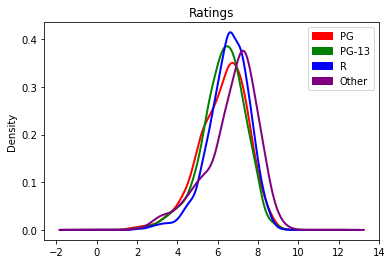

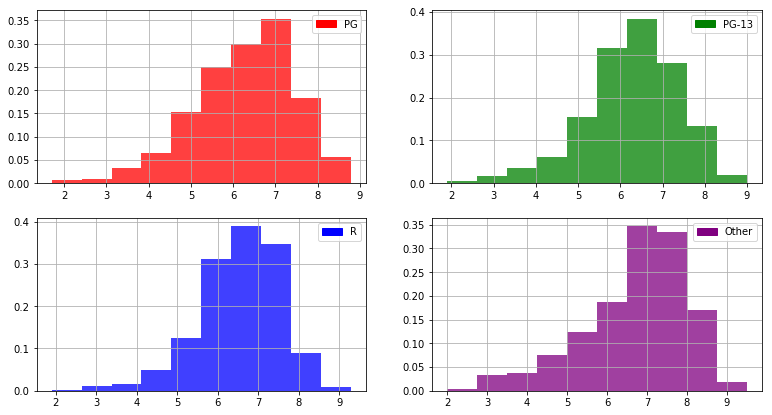

Mean imdb_score for Rating_PG = 1: 6.27436762226
Mean imdb_score for Rating_PG-13 = 1: 6.26590538336
Mean imdb_score for Rating_R = 1: 6.53322422259
Mean imdb_score for Rating_Other = 1: 6.69589905363


In [468]:
colors = ['red','green','blue','purple']
red_patch = mpatches.Patch(color = 'red',label='PG')
green_patch = mpatches.Patch(color = 'green',label='PG-13')
blue_patch = mpatches.Patch(color = 'blue',label='R')
purple_patch = mpatches.Patch(color = 'purple',label='Other')
patches = [red_patch,green_patch,blue_patch,purple_patch]
#Плотности распределений
for i in range(len(ratings)):
    movie_train_data[movie_train_data['Rating_'+ratings[i]] == 1].imdb_score.plot(kind='kde',linewidth = 2,color=colors[i])
plt.legend(handles=patches)
plt.title('Ratings')
plt.show()
#Гистограммы распределений (гистограммы накладываются друг на друга, сделаем их отдельно)
plt.figure(figsize=(13,7))
for i in range(len(ratings)):
    plt.subplot(221 + i)
    movie_train_data[movie_train_data['Rating_'+ratings[i]] == 1].imdb_score.hist(normed=True,alpha=0.75,color=colors[i])
    plt.legend(handles=[patches[i]])
plt.show()
for i in range(len(ratings)):
    print 'Mean imdb_score for Rating_'+ratings[i]+' = 1:',movie_train_data[movie_train_data['Rating_'+ratings[i]] == 1].imdb_score.mean()


#### Разница неочень большая, единственное, что можно выделить, это то, что фильмы с рейтингами PG и PG-13 менее успешные

### Теперь рассмотри признак duration - продолжительность

### Данный признак содержит nan значения, давайте считать что если значение nan, то продолжительность фильма 100 минут (продолжительность среднестатистичекого фильма)

In [481]:
def get_duration(data):
    duration = data.duration.values
    for i in range(len(duration)):
        if duration[i] != duration[i]:
            duration[i] = 100
    return duration
movie_train_data['duration'] = get_duration(movie_train)
movie_test_data['duration'] = get_duration(movie_test)
movie_train_data.to_csv('Movie_Resume\\movie_train_data.csv',sep=',',index=None,header=True)
movie_test_data.to_csv('Movie_Resume\\movie_test_data.csv',sep=',',index=None,header=True)  

### Посмотрим на распределение продолжительности фильма

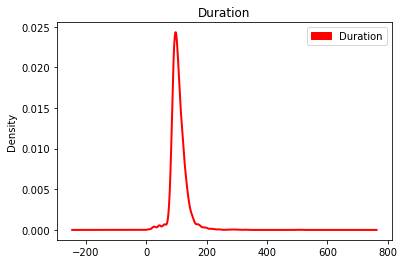

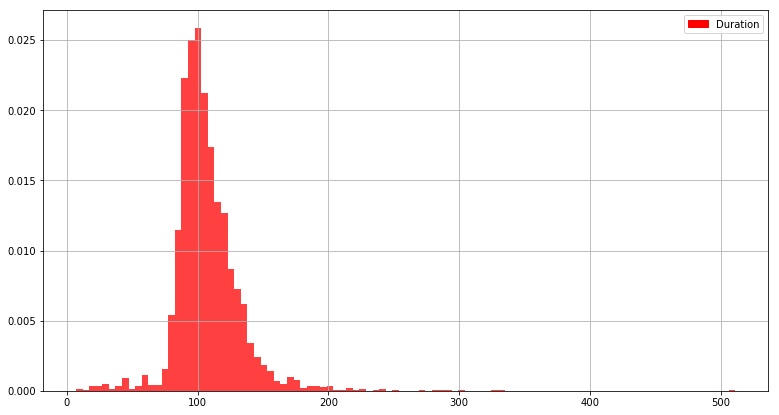

In [484]:
colors = ['red']
red_patch = mpatches.Patch(color = 'red',label='Duration')
patches = [red_patch]
#Плотность распределения
movie_train_data.duration.plot(kind='kde',linewidth = 2,color=colors[0])
plt.legend(handles=patches)
plt.title('Duration')
plt.show()
#Гистограмма распределения
plt.figure(figsize=(13,7))
movie_train_data.duration.hist(normed=True,alpha=0.75,color=colors[0],bins = 100)
plt.legend(handles=[patches[0]])
plt.show()

#### Ярко выраженный пик, очень похоже на нормальное распределение

### Давайте рассмотрим признаки, которые мы еще не использовали. Бюджет, сборы, суммарное количество лайков на facebook, количество лайков фильма на facebook, теги и прочие.
### Сборы и количество лайков фильма на facebook предлагаем не использовать по причине того, что данные признаки очевидно будут сильно коррелировать с оцениваемой переменной, ведь чем популярней фильм, тем лучше оценка, тем лучше сборы. Нам бы хотелось предсказать оценку на стадии разработки фильма. По этой же причине не используем признаки: количество критиков, количество проголосовавших пользователей.
### Рассматривать год выпуска фильма, тоже не нужно, ведь в теории мы раньше 2017-ого года фильм не снимем. 
### Количество лиц на постере рассматривать не будем, по-скольку у многих фильмов банально может быть много различных постеров.
### Соотношение сторон тоже не совсем правильно задйствовать, раньше использовались другие форматы пленок, в настоящее время только Квентин Тарантино уделяет этому признаку внимание.
### Теперь рассмотрим бюджет. Проблема заключается в том, что у многих фильмов он не указан по ряду причин: авторское кино, любительское кино, кино снято давно. Заполнять такие значения нулем было бы не совсем корректно. Давайте зададим стандартную сумму бюджета в 3000000 для тех фильмов, в которых он не указан, также давайте обусловимся считать кино высокобюджетным, если его бюджет выше 50 миллионов долларов, в остальных случаях оно низкобюджетное. 
### Теги являются своего рода аналогом жанра, более точным и конкретным. Их может быть огромное количество, более того их составляют сами пользователи после оценки фильма, соответственно не корректно использовать данный признак


### Приступим к работе на бюджетом

In [82]:
def get_budget(data):
    budget = data.budget.values
    for i in range(len(budget)):
        if budget[i] != budget[i]:
            budget[i] = 3000000
    return budget
movie_train_data['budget'] = get_budget(movie_train)
movie_test_data['budget'] = get_budget(movie_test)
movie_train_data.to_csv('Movie_Resume\\movie_train_data.csv',sep=',',index=None,header=True)
movie_test_data.to_csv('Movie_Resume\\movie_test_data.csv',sep=',',index=None,header=True)  

### Посмотрим на распределение бюджета фильма

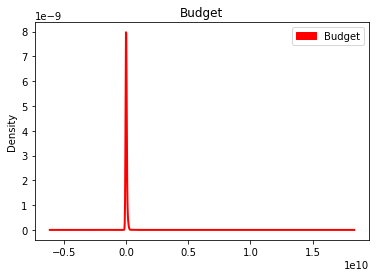

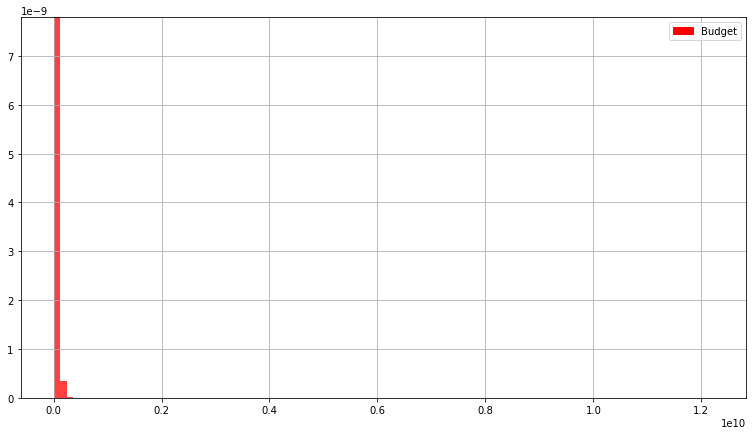

In [99]:
colors = ['red']
red_patch = mpatches.Patch(color = 'red',label='Budget')
patches = [red_patch]
#Плотность распределения
movie_train_data.budget.plot(kind='kde',linewidth = 2,color=colors[0])
plt.legend(handles=patches)
plt.title('Budget')
plt.show()
#Гистограмма распределения
plt.figure(figsize=(13,7))
movie_train_data.budget.hist(normed=True,alpha=0.75,color=colors[0],bins = 100)
plt.legend(handles=[patches[0]])
plt.show()

#### Большинство фильмов имеют небольшой бюджет

In [509]:
def is_high_budget(data):
    budget = data.budget.values
    is_high_budget = []
    for i in range(len(budget)):
        is_high_budget.append(0)
        if budget[i] > 50000000:
            is_high_budget[i] += 1
    return is_high_budget
movie_train_data['is_high_budget'] = is_high_budget(movie_train)
movie_test_data['is_high_budget'] = is_high_budget(movie_test)
movie_train_data.to_csv('Movie_Resume\\movie_train_data.csv',sep=',',index=None,header=True)
movie_test_data.to_csv('Movie_Resume\\movie_test_data.csv',sep=',',index=None,header=True)  

### Теперь посмотрим на значение оценки на imdb в зависиомсти от значения признака

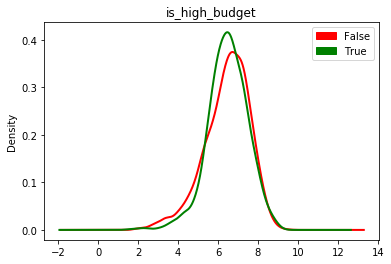

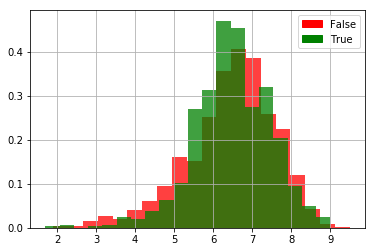

Mean imdb_score for is_high_budget = False: 6.43771754636
Mean imdb_score for is_high_budget = True: 6.47772087068


In [511]:
colors = ['red','green']
red_patch = mpatches.Patch(color = 'red',label='False')
green_patch = mpatches.Patch(color = 'green',label='True')
patches = [red_patch,green_patch]
#Плотности распределений
movie_train_data[movie_train_data['is_high_budget'] == 0].imdb_score.plot(kind='kde',linewidth = 2,color=colors[0])
movie_train_data[movie_train_data['is_high_budget'] == 1].imdb_score.plot(kind='kde',linewidth = 2,color=colors[1])
plt.legend(handles=patches)
plt.title('is_high_budget')
plt.show()
#Гистограммы распределений
movie_train_data[movie_train_data['is_high_budget'] == 0].imdb_score.hist(normed=True,alpha=0.75,color=colors[0], bins = 20)
movie_train_data[movie_train_data['is_high_budget'] == 1].imdb_score.hist(normed=True,alpha=0.75,color=colors[1], bins = 20)
plt.legend(handles=patches)
plt.show()


print 'Mean imdb_score for is_high_budget = False:',movie_train_data[movie_train_data['is_high_budget'] == 0].imdb_score.mean()
print 'Mean imdb_score for is_high_budget = True:',movie_train_data[movie_train_data['is_high_budget'] == 1].imdb_score.mean()


#### Разница в средней оценки минимальна

### Добавим признак суммарное количество лайков на facebook у съемочной группы фильма

In [95]:
def get_cast_total_likes(data):
    return data.cast_total_facebook_likes.values
movie_train_data['cast_total_facebook_likes'] = get_cast_total_likes(movie_train)
movie_test_data['cast_total_facebook_likes'] = get_cast_total_likes(movie_test)
movie_train_data.to_csv('Movie_Resume\\movie_train_data.csv',sep=',',index=None,header=True)
movie_test_data.to_csv('Movie_Resume\\movie_test_data.csv',sep=',',index=None,header=True)  

### Посмотрим на распределение суммарного количества лайков

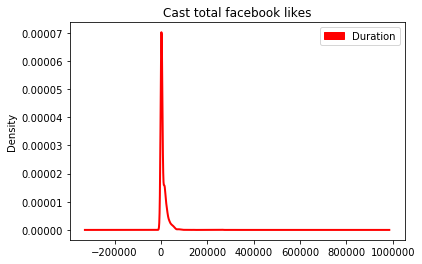

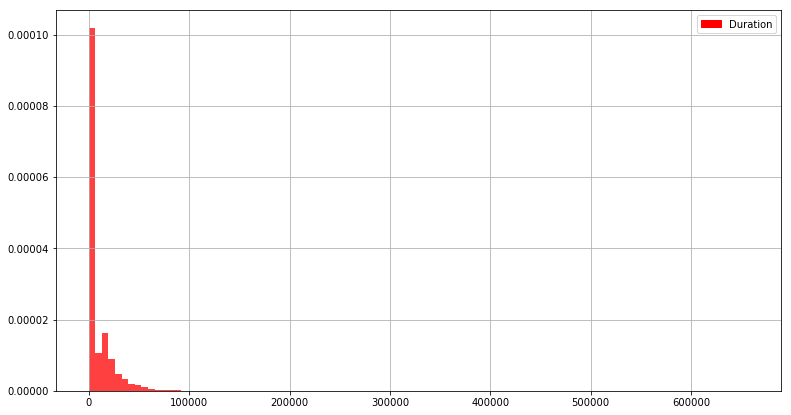

In [100]:
colors = ['red']
red_patch = mpatches.Patch(color = 'red',label='Duration')
patches = [red_patch]
#Плотность распределения
movie_train_data.cast_total_facebook_likes.plot(kind='kde',linewidth = 2,color=colors[0])
plt.legend(handles=patches)
plt.title('Cast total facebook likes')
plt.show()
#Гистограмма распределения
plt.figure(figsize=(13,7))
movie_train_data.cast_total_facebook_likes.hist(normed=True,alpha=0.75,color=colors[0],bins = 100)
plt.legend(handles=[patches[0]])
plt.show()

#### Распределение имеет ярко выраженный пик

### Мы наконец составили тренировочную и тестовую выборку, давайте попробуем решить задачу регрессии

In [2]:
movie_train_data = pd.read_csv('Movie_Resume\\movie_train_data.csv')
movie_test_data = pd.read_csv('Movie_Resume\\movie_test_data.csv')

In [6]:
std_scaler = StandardScaler()
train_data = std_scaler.fit_transform(movie_train_data)
X_train = train_data.transpose()[1:].transpose()
Y_train = movie_train_data.imdb_score.values

test_data = std_scaler.fit_transform(movie_test_data)
X_test = test_data.transpose()[1:].transpose()
Y_test = movie_test_data.imdb_score.values



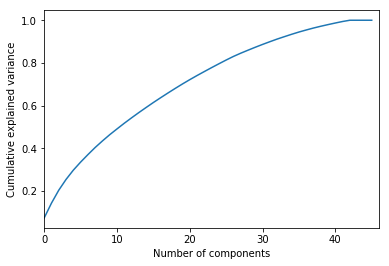

In [7]:
pca = PCA().fit(X_train,Y_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,46,1)

plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [227]:
pca = PCA(n_components=42)
X_train = pca.fit_transform(X_train,Y_train)
X_test = pca.transform(X_test)

X_test, X_valid, Y_test, Y_valid = train_test_split(X_test,Y_test,random_state = 42, test_size = 0.5)

In [212]:
parameters = {'bagging_fraction': [0.7, 0.8, 0.9],
 'feature_fraction': [0.7, 0.8, 0.9],
 'max_depth': [1, 5, 7],
 'min_data_in_leaf': [5, 7, 9, 11, 13],
 'num_leaves': [5, 7, 9, 11],
 'objective': ['regression_l2'],
 'reg_alpha': [8, 9, 5],
 'reg_lambda': [0.5, 0.1, 0.01]}
parameters_combo = list(product(parameters['objective'],
            parameters['min_data_in_leaf'],
             parameters['feature_fraction'],
             parameters['bagging_fraction'],
             parameters['max_depth'],
             parameters['reg_alpha'],
             parameters['reg_lambda'],
             parameters['num_leaves']))

In [5]:
# Вспомним, что, если прогнозируемое значение не подпадает в промежуток [0.0 : 10.0] мы это исправим
def make_good_predict(data):
    for i in range(len(data)):
        if data[i] < 0.0:
            data[i] = 0.0
        if data[i] > 10.0:
            data[i] = 10.0
    return data

In [213]:
results = []
for i in range(len(parameters_combo)):
    gbm = lgb.LGBMRegressor(nthread = -1, objective=parameters_combo[i][0],
                        min_data_in_leaf = parameters_combo[i][1],
                        feature_fraction = parameters_combo[i][2],
                        bagging_fraction = parameters_combo[i][3],
                        max_depth = parameters_combo[i][4],
                        reg_alpha = parameters_combo[i][5],
                        reg_lambda = parameters_combo[i][6],
                        num_leaves = parameters_combo[i][7],
                        learning_rate = 0.1,
                        n_estimators = 100)
    gbm.fit(X_train, Y_train,
        eval_set=[(X_valid, Y_valid)],
        eval_metric = 'l2',
        verbose = False,
        early_stopping_rounds=10)
    print 'Iteration ',i,'parameters',parameters_combo[i]
    Y_valid_predict = make_good_predict(gbm.predict(X_valid))
    results.append((i,
                    mean_absolute_error(Y_valid,Y_valid_predict),
                   mean_squared_error(Y_valid,Y_valid_predict),
                   explained_variance_score(Y_valid,Y_valid_predict),
                   r2_score(Y_valid,Y_valid_predict)))   

Iteration  0 parameters ('regression_l2', 5, 0.7, 0.7, 1, 8, 0.5, 5)
Iteration  1 parameters ('regression_l2', 5, 0.7, 0.7, 1, 8, 0.5, 7)
Iteration  2 parameters ('regression_l2', 5, 0.7, 0.7, 1, 8, 0.5, 9)
Iteration  3 parameters ('regression_l2', 5, 0.7, 0.7, 1, 8, 0.5, 11)
Iteration  4 parameters ('regression_l2', 5, 0.7, 0.7, 1, 8, 0.1, 5)
Iteration  5 parameters ('regression_l2', 5, 0.7, 0.7, 1, 8, 0.1, 7)
Iteration  6 parameters ('regression_l2', 5, 0.7, 0.7, 1, 8, 0.1, 9)
Iteration  7 parameters ('regression_l2', 5, 0.7, 0.7, 1, 8, 0.1, 11)
Iteration  8 parameters ('regression_l2', 5, 0.7, 0.7, 1, 8, 0.01, 5)
Iteration  9 parameters ('regression_l2', 5, 0.7, 0.7, 1, 8, 0.01, 7)
Iteration  10 parameters ('regression_l2', 5, 0.7, 0.7, 1, 8, 0.01, 9)
Iteration  11 parameters ('regression_l2', 5, 0.7, 0.7, 1, 8, 0.01, 11)
Iteration  12 parameters ('regression_l2', 5, 0.7, 0.7, 1, 9, 0.5, 5)
Iteration  13 parameters ('regression_l2', 5, 0.7, 0.7, 1, 9, 0.5, 7)
Iteration  14 parameter

Iteration  118 parameters ('regression_l2', 5, 0.7, 0.8, 1, 8, 0.01, 9)
Iteration  119 parameters ('regression_l2', 5, 0.7, 0.8, 1, 8, 0.01, 11)
Iteration  120 parameters ('regression_l2', 5, 0.7, 0.8, 1, 9, 0.5, 5)
Iteration  121 parameters ('regression_l2', 5, 0.7, 0.8, 1, 9, 0.5, 7)
Iteration  122 parameters ('regression_l2', 5, 0.7, 0.8, 1, 9, 0.5, 9)
Iteration  123 parameters ('regression_l2', 5, 0.7, 0.8, 1, 9, 0.5, 11)
Iteration  124 parameters ('regression_l2', 5, 0.7, 0.8, 1, 9, 0.1, 5)
Iteration  125 parameters ('regression_l2', 5, 0.7, 0.8, 1, 9, 0.1, 7)
Iteration  126 parameters ('regression_l2', 5, 0.7, 0.8, 1, 9, 0.1, 9)
Iteration  127 parameters ('regression_l2', 5, 0.7, 0.8, 1, 9, 0.1, 11)
Iteration  128 parameters ('regression_l2', 5, 0.7, 0.8, 1, 9, 0.01, 5)
Iteration  129 parameters ('regression_l2', 5, 0.7, 0.8, 1, 9, 0.01, 7)
Iteration  130 parameters ('regression_l2', 5, 0.7, 0.8, 1, 9, 0.01, 9)
Iteration  131 parameters ('regression_l2', 5, 0.7, 0.8, 1, 9, 0.01, 

Iteration  233 parameters ('regression_l2', 5, 0.7, 0.9, 1, 9, 0.1, 7)
Iteration  234 parameters ('regression_l2', 5, 0.7, 0.9, 1, 9, 0.1, 9)
Iteration  235 parameters ('regression_l2', 5, 0.7, 0.9, 1, 9, 0.1, 11)
Iteration  236 parameters ('regression_l2', 5, 0.7, 0.9, 1, 9, 0.01, 5)
Iteration  237 parameters ('regression_l2', 5, 0.7, 0.9, 1, 9, 0.01, 7)
Iteration  238 parameters ('regression_l2', 5, 0.7, 0.9, 1, 9, 0.01, 9)
Iteration  239 parameters ('regression_l2', 5, 0.7, 0.9, 1, 9, 0.01, 11)
Iteration  240 parameters ('regression_l2', 5, 0.7, 0.9, 1, 5, 0.5, 5)
Iteration  241 parameters ('regression_l2', 5, 0.7, 0.9, 1, 5, 0.5, 7)
Iteration  242 parameters ('regression_l2', 5, 0.7, 0.9, 1, 5, 0.5, 9)
Iteration  243 parameters ('regression_l2', 5, 0.7, 0.9, 1, 5, 0.5, 11)
Iteration  244 parameters ('regression_l2', 5, 0.7, 0.9, 1, 5, 0.1, 5)
Iteration  245 parameters ('regression_l2', 5, 0.7, 0.9, 1, 5, 0.1, 7)
Iteration  246 parameters ('regression_l2', 5, 0.7, 0.9, 1, 5, 0.1, 9)

Iteration  350 parameters ('regression_l2', 5, 0.8, 0.7, 1, 5, 0.5, 9)
Iteration  351 parameters ('regression_l2', 5, 0.8, 0.7, 1, 5, 0.5, 11)
Iteration  352 parameters ('regression_l2', 5, 0.8, 0.7, 1, 5, 0.1, 5)
Iteration  353 parameters ('regression_l2', 5, 0.8, 0.7, 1, 5, 0.1, 7)
Iteration  354 parameters ('regression_l2', 5, 0.8, 0.7, 1, 5, 0.1, 9)
Iteration  355 parameters ('regression_l2', 5, 0.8, 0.7, 1, 5, 0.1, 11)
Iteration  356 parameters ('regression_l2', 5, 0.8, 0.7, 1, 5, 0.01, 5)
Iteration  357 parameters ('regression_l2', 5, 0.8, 0.7, 1, 5, 0.01, 7)
Iteration  358 parameters ('regression_l2', 5, 0.8, 0.7, 1, 5, 0.01, 9)
Iteration  359 parameters ('regression_l2', 5, 0.8, 0.7, 1, 5, 0.01, 11)
Iteration  360 parameters ('regression_l2', 5, 0.8, 0.7, 5, 8, 0.5, 5)
Iteration  361 parameters ('regression_l2', 5, 0.8, 0.7, 5, 8, 0.5, 7)
Iteration  362 parameters ('regression_l2', 5, 0.8, 0.7, 5, 8, 0.5, 9)
Iteration  363 parameters ('regression_l2', 5, 0.8, 0.7, 5, 8, 0.5, 11

Iteration  467 parameters ('regression_l2', 5, 0.8, 0.8, 1, 5, 0.01, 11)
Iteration  468 parameters ('regression_l2', 5, 0.8, 0.8, 5, 8, 0.5, 5)
Iteration  469 parameters ('regression_l2', 5, 0.8, 0.8, 5, 8, 0.5, 7)
Iteration  470 parameters ('regression_l2', 5, 0.8, 0.8, 5, 8, 0.5, 9)
Iteration  471 parameters ('regression_l2', 5, 0.8, 0.8, 5, 8, 0.5, 11)
Iteration  472 parameters ('regression_l2', 5, 0.8, 0.8, 5, 8, 0.1, 5)
Iteration  473 parameters ('regression_l2', 5, 0.8, 0.8, 5, 8, 0.1, 7)
Iteration  474 parameters ('regression_l2', 5, 0.8, 0.8, 5, 8, 0.1, 9)
Iteration  475 parameters ('regression_l2', 5, 0.8, 0.8, 5, 8, 0.1, 11)
Iteration  476 parameters ('regression_l2', 5, 0.8, 0.8, 5, 8, 0.01, 5)
Iteration  477 parameters ('regression_l2', 5, 0.8, 0.8, 5, 8, 0.01, 7)
Iteration  478 parameters ('regression_l2', 5, 0.8, 0.8, 5, 8, 0.01, 9)
Iteration  479 parameters ('regression_l2', 5, 0.8, 0.8, 5, 8, 0.01, 11)
Iteration  480 parameters ('regression_l2', 5, 0.8, 0.8, 5, 9, 0.5, 

Iteration  583 parameters ('regression_l2', 5, 0.8, 0.9, 5, 8, 0.1, 11)
Iteration  584 parameters ('regression_l2', 5, 0.8, 0.9, 5, 8, 0.01, 5)
Iteration  585 parameters ('regression_l2', 5, 0.8, 0.9, 5, 8, 0.01, 7)
Iteration  586 parameters ('regression_l2', 5, 0.8, 0.9, 5, 8, 0.01, 9)
Iteration  587 parameters ('regression_l2', 5, 0.8, 0.9, 5, 8, 0.01, 11)
Iteration  588 parameters ('regression_l2', 5, 0.8, 0.9, 5, 9, 0.5, 5)
Iteration  589 parameters ('regression_l2', 5, 0.8, 0.9, 5, 9, 0.5, 7)
Iteration  590 parameters ('regression_l2', 5, 0.8, 0.9, 5, 9, 0.5, 9)
Iteration  591 parameters ('regression_l2', 5, 0.8, 0.9, 5, 9, 0.5, 11)
Iteration  592 parameters ('regression_l2', 5, 0.8, 0.9, 5, 9, 0.1, 5)
Iteration  593 parameters ('regression_l2', 5, 0.8, 0.9, 5, 9, 0.1, 7)
Iteration  594 parameters ('regression_l2', 5, 0.8, 0.9, 5, 9, 0.1, 9)
Iteration  595 parameters ('regression_l2', 5, 0.8, 0.9, 5, 9, 0.1, 11)
Iteration  596 parameters ('regression_l2', 5, 0.8, 0.9, 5, 9, 0.01, 

Iteration  699 parameters ('regression_l2', 5, 0.9, 0.7, 5, 9, 0.5, 11)
Iteration  700 parameters ('regression_l2', 5, 0.9, 0.7, 5, 9, 0.1, 5)
Iteration  701 parameters ('regression_l2', 5, 0.9, 0.7, 5, 9, 0.1, 7)
Iteration  702 parameters ('regression_l2', 5, 0.9, 0.7, 5, 9, 0.1, 9)
Iteration  703 parameters ('regression_l2', 5, 0.9, 0.7, 5, 9, 0.1, 11)
Iteration  704 parameters ('regression_l2', 5, 0.9, 0.7, 5, 9, 0.01, 5)
Iteration  705 parameters ('regression_l2', 5, 0.9, 0.7, 5, 9, 0.01, 7)
Iteration  706 parameters ('regression_l2', 5, 0.9, 0.7, 5, 9, 0.01, 9)
Iteration  707 parameters ('regression_l2', 5, 0.9, 0.7, 5, 9, 0.01, 11)
Iteration  708 parameters ('regression_l2', 5, 0.9, 0.7, 5, 5, 0.5, 5)
Iteration  709 parameters ('regression_l2', 5, 0.9, 0.7, 5, 5, 0.5, 7)
Iteration  710 parameters ('regression_l2', 5, 0.9, 0.7, 5, 5, 0.5, 9)
Iteration  711 parameters ('regression_l2', 5, 0.9, 0.7, 5, 5, 0.5, 11)
Iteration  712 parameters ('regression_l2', 5, 0.9, 0.7, 5, 5, 0.1, 5

Iteration  815 parameters ('regression_l2', 5, 0.9, 0.8, 5, 9, 0.01, 11)
Iteration  816 parameters ('regression_l2', 5, 0.9, 0.8, 5, 5, 0.5, 5)
Iteration  817 parameters ('regression_l2', 5, 0.9, 0.8, 5, 5, 0.5, 7)
Iteration  818 parameters ('regression_l2', 5, 0.9, 0.8, 5, 5, 0.5, 9)
Iteration  819 parameters ('regression_l2', 5, 0.9, 0.8, 5, 5, 0.5, 11)
Iteration  820 parameters ('regression_l2', 5, 0.9, 0.8, 5, 5, 0.1, 5)
Iteration  821 parameters ('regression_l2', 5, 0.9, 0.8, 5, 5, 0.1, 7)
Iteration  822 parameters ('regression_l2', 5, 0.9, 0.8, 5, 5, 0.1, 9)
Iteration  823 parameters ('regression_l2', 5, 0.9, 0.8, 5, 5, 0.1, 11)
Iteration  824 parameters ('regression_l2', 5, 0.9, 0.8, 5, 5, 0.01, 5)
Iteration  825 parameters ('regression_l2', 5, 0.9, 0.8, 5, 5, 0.01, 7)
Iteration  826 parameters ('regression_l2', 5, 0.9, 0.8, 5, 5, 0.01, 9)
Iteration  827 parameters ('regression_l2', 5, 0.9, 0.8, 5, 5, 0.01, 11)
Iteration  828 parameters ('regression_l2', 5, 0.9, 0.8, 7, 8, 0.5, 

Iteration  931 parameters ('regression_l2', 5, 0.9, 0.9, 5, 5, 0.1, 11)
Iteration  932 parameters ('regression_l2', 5, 0.9, 0.9, 5, 5, 0.01, 5)
Iteration  933 parameters ('regression_l2', 5, 0.9, 0.9, 5, 5, 0.01, 7)
Iteration  934 parameters ('regression_l2', 5, 0.9, 0.9, 5, 5, 0.01, 9)
Iteration  935 parameters ('regression_l2', 5, 0.9, 0.9, 5, 5, 0.01, 11)
Iteration  936 parameters ('regression_l2', 5, 0.9, 0.9, 7, 8, 0.5, 5)
Iteration  937 parameters ('regression_l2', 5, 0.9, 0.9, 7, 8, 0.5, 7)
Iteration  938 parameters ('regression_l2', 5, 0.9, 0.9, 7, 8, 0.5, 9)
Iteration  939 parameters ('regression_l2', 5, 0.9, 0.9, 7, 8, 0.5, 11)
Iteration  940 parameters ('regression_l2', 5, 0.9, 0.9, 7, 8, 0.1, 5)
Iteration  941 parameters ('regression_l2', 5, 0.9, 0.9, 7, 8, 0.1, 7)
Iteration  942 parameters ('regression_l2', 5, 0.9, 0.9, 7, 8, 0.1, 9)
Iteration  943 parameters ('regression_l2', 5, 0.9, 0.9, 7, 8, 0.1, 11)
Iteration  944 parameters ('regression_l2', 5, 0.9, 0.9, 7, 8, 0.01, 

Iteration  1045 parameters ('regression_l2', 7, 0.7, 0.7, 7, 8, 0.5, 7)
Iteration  1046 parameters ('regression_l2', 7, 0.7, 0.7, 7, 8, 0.5, 9)
Iteration  1047 parameters ('regression_l2', 7, 0.7, 0.7, 7, 8, 0.5, 11)
Iteration  1048 parameters ('regression_l2', 7, 0.7, 0.7, 7, 8, 0.1, 5)
Iteration  1049 parameters ('regression_l2', 7, 0.7, 0.7, 7, 8, 0.1, 7)
Iteration  1050 parameters ('regression_l2', 7, 0.7, 0.7, 7, 8, 0.1, 9)
Iteration  1051 parameters ('regression_l2', 7, 0.7, 0.7, 7, 8, 0.1, 11)
Iteration  1052 parameters ('regression_l2', 7, 0.7, 0.7, 7, 8, 0.01, 5)
Iteration  1053 parameters ('regression_l2', 7, 0.7, 0.7, 7, 8, 0.01, 7)
Iteration  1054 parameters ('regression_l2', 7, 0.7, 0.7, 7, 8, 0.01, 9)
Iteration  1055 parameters ('regression_l2', 7, 0.7, 0.7, 7, 8, 0.01, 11)
Iteration  1056 parameters ('regression_l2', 7, 0.7, 0.7, 7, 9, 0.5, 5)
Iteration  1057 parameters ('regression_l2', 7, 0.7, 0.7, 7, 9, 0.5, 7)
Iteration  1058 parameters ('regression_l2', 7, 0.7, 0.7,

Iteration  1159 parameters ('regression_l2', 7, 0.7, 0.8, 7, 8, 0.1, 11)
Iteration  1160 parameters ('regression_l2', 7, 0.7, 0.8, 7, 8, 0.01, 5)
Iteration  1161 parameters ('regression_l2', 7, 0.7, 0.8, 7, 8, 0.01, 7)
Iteration  1162 parameters ('regression_l2', 7, 0.7, 0.8, 7, 8, 0.01, 9)
Iteration  1163 parameters ('regression_l2', 7, 0.7, 0.8, 7, 8, 0.01, 11)
Iteration  1164 parameters ('regression_l2', 7, 0.7, 0.8, 7, 9, 0.5, 5)
Iteration  1165 parameters ('regression_l2', 7, 0.7, 0.8, 7, 9, 0.5, 7)
Iteration  1166 parameters ('regression_l2', 7, 0.7, 0.8, 7, 9, 0.5, 9)
Iteration  1167 parameters ('regression_l2', 7, 0.7, 0.8, 7, 9, 0.5, 11)
Iteration  1168 parameters ('regression_l2', 7, 0.7, 0.8, 7, 9, 0.1, 5)
Iteration  1169 parameters ('regression_l2', 7, 0.7, 0.8, 7, 9, 0.1, 7)
Iteration  1170 parameters ('regression_l2', 7, 0.7, 0.8, 7, 9, 0.1, 9)
Iteration  1171 parameters ('regression_l2', 7, 0.7, 0.8, 7, 9, 0.1, 11)
Iteration  1172 parameters ('regression_l2', 7, 0.7, 0.8

Iteration  1273 parameters ('regression_l2', 7, 0.7, 0.9, 7, 9, 0.5, 7)
Iteration  1274 parameters ('regression_l2', 7, 0.7, 0.9, 7, 9, 0.5, 9)
Iteration  1275 parameters ('regression_l2', 7, 0.7, 0.9, 7, 9, 0.5, 11)
Iteration  1276 parameters ('regression_l2', 7, 0.7, 0.9, 7, 9, 0.1, 5)
Iteration  1277 parameters ('regression_l2', 7, 0.7, 0.9, 7, 9, 0.1, 7)
Iteration  1278 parameters ('regression_l2', 7, 0.7, 0.9, 7, 9, 0.1, 9)
Iteration  1279 parameters ('regression_l2', 7, 0.7, 0.9, 7, 9, 0.1, 11)
Iteration  1280 parameters ('regression_l2', 7, 0.7, 0.9, 7, 9, 0.01, 5)
Iteration  1281 parameters ('regression_l2', 7, 0.7, 0.9, 7, 9, 0.01, 7)
Iteration  1282 parameters ('regression_l2', 7, 0.7, 0.9, 7, 9, 0.01, 9)
Iteration  1283 parameters ('regression_l2', 7, 0.7, 0.9, 7, 9, 0.01, 11)
Iteration  1284 parameters ('regression_l2', 7, 0.7, 0.9, 7, 5, 0.5, 5)
Iteration  1285 parameters ('regression_l2', 7, 0.7, 0.9, 7, 5, 0.5, 7)
Iteration  1286 parameters ('regression_l2', 7, 0.7, 0.9,

Iteration  1387 parameters ('regression_l2', 7, 0.8, 0.7, 7, 9, 0.1, 11)
Iteration  1388 parameters ('regression_l2', 7, 0.8, 0.7, 7, 9, 0.01, 5)
Iteration  1389 parameters ('regression_l2', 7, 0.8, 0.7, 7, 9, 0.01, 7)
Iteration  1390 parameters ('regression_l2', 7, 0.8, 0.7, 7, 9, 0.01, 9)
Iteration  1391 parameters ('regression_l2', 7, 0.8, 0.7, 7, 9, 0.01, 11)
Iteration  1392 parameters ('regression_l2', 7, 0.8, 0.7, 7, 5, 0.5, 5)
Iteration  1393 parameters ('regression_l2', 7, 0.8, 0.7, 7, 5, 0.5, 7)
Iteration  1394 parameters ('regression_l2', 7, 0.8, 0.7, 7, 5, 0.5, 9)
Iteration  1395 parameters ('regression_l2', 7, 0.8, 0.7, 7, 5, 0.5, 11)
Iteration  1396 parameters ('regression_l2', 7, 0.8, 0.7, 7, 5, 0.1, 5)
Iteration  1397 parameters ('regression_l2', 7, 0.8, 0.7, 7, 5, 0.1, 7)
Iteration  1398 parameters ('regression_l2', 7, 0.8, 0.7, 7, 5, 0.1, 9)
Iteration  1399 parameters ('regression_l2', 7, 0.8, 0.7, 7, 5, 0.1, 11)
Iteration  1400 parameters ('regression_l2', 7, 0.8, 0.7

Iteration  1501 parameters ('regression_l2', 7, 0.8, 0.8, 7, 5, 0.5, 7)
Iteration  1502 parameters ('regression_l2', 7, 0.8, 0.8, 7, 5, 0.5, 9)
Iteration  1503 parameters ('regression_l2', 7, 0.8, 0.8, 7, 5, 0.5, 11)
Iteration  1504 parameters ('regression_l2', 7, 0.8, 0.8, 7, 5, 0.1, 5)
Iteration  1505 parameters ('regression_l2', 7, 0.8, 0.8, 7, 5, 0.1, 7)
Iteration  1506 parameters ('regression_l2', 7, 0.8, 0.8, 7, 5, 0.1, 9)
Iteration  1507 parameters ('regression_l2', 7, 0.8, 0.8, 7, 5, 0.1, 11)
Iteration  1508 parameters ('regression_l2', 7, 0.8, 0.8, 7, 5, 0.01, 5)
Iteration  1509 parameters ('regression_l2', 7, 0.8, 0.8, 7, 5, 0.01, 7)
Iteration  1510 parameters ('regression_l2', 7, 0.8, 0.8, 7, 5, 0.01, 9)
Iteration  1511 parameters ('regression_l2', 7, 0.8, 0.8, 7, 5, 0.01, 11)
Iteration  1512 parameters ('regression_l2', 7, 0.8, 0.9, 1, 8, 0.5, 5)
Iteration  1513 parameters ('regression_l2', 7, 0.8, 0.9, 1, 8, 0.5, 7)
Iteration  1514 parameters ('regression_l2', 7, 0.8, 0.9,

Iteration  1615 parameters ('regression_l2', 7, 0.8, 0.9, 7, 5, 0.1, 11)
Iteration  1616 parameters ('regression_l2', 7, 0.8, 0.9, 7, 5, 0.01, 5)
Iteration  1617 parameters ('regression_l2', 7, 0.8, 0.9, 7, 5, 0.01, 7)
Iteration  1618 parameters ('regression_l2', 7, 0.8, 0.9, 7, 5, 0.01, 9)
Iteration  1619 parameters ('regression_l2', 7, 0.8, 0.9, 7, 5, 0.01, 11)
Iteration  1620 parameters ('regression_l2', 7, 0.9, 0.7, 1, 8, 0.5, 5)
Iteration  1621 parameters ('regression_l2', 7, 0.9, 0.7, 1, 8, 0.5, 7)
Iteration  1622 parameters ('regression_l2', 7, 0.9, 0.7, 1, 8, 0.5, 9)
Iteration  1623 parameters ('regression_l2', 7, 0.9, 0.7, 1, 8, 0.5, 11)
Iteration  1624 parameters ('regression_l2', 7, 0.9, 0.7, 1, 8, 0.1, 5)
Iteration  1625 parameters ('regression_l2', 7, 0.9, 0.7, 1, 8, 0.1, 7)
Iteration  1626 parameters ('regression_l2', 7, 0.9, 0.7, 1, 8, 0.1, 9)
Iteration  1627 parameters ('regression_l2', 7, 0.9, 0.7, 1, 8, 0.1, 11)
Iteration  1628 parameters ('regression_l2', 7, 0.9, 0.7

Iteration  1730 parameters ('regression_l2', 7, 0.9, 0.8, 1, 8, 0.5, 9)
Iteration  1731 parameters ('regression_l2', 7, 0.9, 0.8, 1, 8, 0.5, 11)
Iteration  1732 parameters ('regression_l2', 7, 0.9, 0.8, 1, 8, 0.1, 5)
Iteration  1733 parameters ('regression_l2', 7, 0.9, 0.8, 1, 8, 0.1, 7)
Iteration  1734 parameters ('regression_l2', 7, 0.9, 0.8, 1, 8, 0.1, 9)
Iteration  1735 parameters ('regression_l2', 7, 0.9, 0.8, 1, 8, 0.1, 11)
Iteration  1736 parameters ('regression_l2', 7, 0.9, 0.8, 1, 8, 0.01, 5)
Iteration  1737 parameters ('regression_l2', 7, 0.9, 0.8, 1, 8, 0.01, 7)
Iteration  1738 parameters ('regression_l2', 7, 0.9, 0.8, 1, 8, 0.01, 9)
Iteration  1739 parameters ('regression_l2', 7, 0.9, 0.8, 1, 8, 0.01, 11)
Iteration  1740 parameters ('regression_l2', 7, 0.9, 0.8, 1, 9, 0.5, 5)
Iteration  1741 parameters ('regression_l2', 7, 0.9, 0.8, 1, 9, 0.5, 7)
Iteration  1742 parameters ('regression_l2', 7, 0.9, 0.8, 1, 9, 0.5, 9)
Iteration  1743 parameters ('regression_l2', 7, 0.9, 0.8,

Iteration  1844 parameters ('regression_l2', 7, 0.9, 0.9, 1, 8, 0.01, 5)
Iteration  1845 parameters ('regression_l2', 7, 0.9, 0.9, 1, 8, 0.01, 7)
Iteration  1846 parameters ('regression_l2', 7, 0.9, 0.9, 1, 8, 0.01, 9)
Iteration  1847 parameters ('regression_l2', 7, 0.9, 0.9, 1, 8, 0.01, 11)
Iteration  1848 parameters ('regression_l2', 7, 0.9, 0.9, 1, 9, 0.5, 5)
Iteration  1849 parameters ('regression_l2', 7, 0.9, 0.9, 1, 9, 0.5, 7)
Iteration  1850 parameters ('regression_l2', 7, 0.9, 0.9, 1, 9, 0.5, 9)
Iteration  1851 parameters ('regression_l2', 7, 0.9, 0.9, 1, 9, 0.5, 11)
Iteration  1852 parameters ('regression_l2', 7, 0.9, 0.9, 1, 9, 0.1, 5)
Iteration  1853 parameters ('regression_l2', 7, 0.9, 0.9, 1, 9, 0.1, 7)
Iteration  1854 parameters ('regression_l2', 7, 0.9, 0.9, 1, 9, 0.1, 9)
Iteration  1855 parameters ('regression_l2', 7, 0.9, 0.9, 1, 9, 0.1, 11)
Iteration  1856 parameters ('regression_l2', 7, 0.9, 0.9, 1, 9, 0.01, 5)
Iteration  1857 parameters ('regression_l2', 7, 0.9, 0.9

Iteration  1958 parameters ('regression_l2', 9, 0.7, 0.7, 1, 9, 0.5, 9)
Iteration  1959 parameters ('regression_l2', 9, 0.7, 0.7, 1, 9, 0.5, 11)
Iteration  1960 parameters ('regression_l2', 9, 0.7, 0.7, 1, 9, 0.1, 5)
Iteration  1961 parameters ('regression_l2', 9, 0.7, 0.7, 1, 9, 0.1, 7)
Iteration  1962 parameters ('regression_l2', 9, 0.7, 0.7, 1, 9, 0.1, 9)
Iteration  1963 parameters ('regression_l2', 9, 0.7, 0.7, 1, 9, 0.1, 11)
Iteration  1964 parameters ('regression_l2', 9, 0.7, 0.7, 1, 9, 0.01, 5)
Iteration  1965 parameters ('regression_l2', 9, 0.7, 0.7, 1, 9, 0.01, 7)
Iteration  1966 parameters ('regression_l2', 9, 0.7, 0.7, 1, 9, 0.01, 9)
Iteration  1967 parameters ('regression_l2', 9, 0.7, 0.7, 1, 9, 0.01, 11)
Iteration  1968 parameters ('regression_l2', 9, 0.7, 0.7, 1, 5, 0.5, 5)
Iteration  1969 parameters ('regression_l2', 9, 0.7, 0.7, 1, 5, 0.5, 7)
Iteration  1970 parameters ('regression_l2', 9, 0.7, 0.7, 1, 5, 0.5, 9)
Iteration  1971 parameters ('regression_l2', 9, 0.7, 0.7,

Iteration  2072 parameters ('regression_l2', 9, 0.7, 0.8, 1, 9, 0.01, 5)
Iteration  2073 parameters ('regression_l2', 9, 0.7, 0.8, 1, 9, 0.01, 7)
Iteration  2074 parameters ('regression_l2', 9, 0.7, 0.8, 1, 9, 0.01, 9)
Iteration  2075 parameters ('regression_l2', 9, 0.7, 0.8, 1, 9, 0.01, 11)
Iteration  2076 parameters ('regression_l2', 9, 0.7, 0.8, 1, 5, 0.5, 5)
Iteration  2077 parameters ('regression_l2', 9, 0.7, 0.8, 1, 5, 0.5, 7)
Iteration  2078 parameters ('regression_l2', 9, 0.7, 0.8, 1, 5, 0.5, 9)
Iteration  2079 parameters ('regression_l2', 9, 0.7, 0.8, 1, 5, 0.5, 11)
Iteration  2080 parameters ('regression_l2', 9, 0.7, 0.8, 1, 5, 0.1, 5)
Iteration  2081 parameters ('regression_l2', 9, 0.7, 0.8, 1, 5, 0.1, 7)
Iteration  2082 parameters ('regression_l2', 9, 0.7, 0.8, 1, 5, 0.1, 9)
Iteration  2083 parameters ('regression_l2', 9, 0.7, 0.8, 1, 5, 0.1, 11)
Iteration  2084 parameters ('regression_l2', 9, 0.7, 0.8, 1, 5, 0.01, 5)
Iteration  2085 parameters ('regression_l2', 9, 0.7, 0.8

Iteration  2186 parameters ('regression_l2', 9, 0.7, 0.9, 1, 5, 0.5, 9)
Iteration  2187 parameters ('regression_l2', 9, 0.7, 0.9, 1, 5, 0.5, 11)
Iteration  2188 parameters ('regression_l2', 9, 0.7, 0.9, 1, 5, 0.1, 5)
Iteration  2189 parameters ('regression_l2', 9, 0.7, 0.9, 1, 5, 0.1, 7)
Iteration  2190 parameters ('regression_l2', 9, 0.7, 0.9, 1, 5, 0.1, 9)
Iteration  2191 parameters ('regression_l2', 9, 0.7, 0.9, 1, 5, 0.1, 11)
Iteration  2192 parameters ('regression_l2', 9, 0.7, 0.9, 1, 5, 0.01, 5)
Iteration  2193 parameters ('regression_l2', 9, 0.7, 0.9, 1, 5, 0.01, 7)
Iteration  2194 parameters ('regression_l2', 9, 0.7, 0.9, 1, 5, 0.01, 9)
Iteration  2195 parameters ('regression_l2', 9, 0.7, 0.9, 1, 5, 0.01, 11)
Iteration  2196 parameters ('regression_l2', 9, 0.7, 0.9, 5, 8, 0.5, 5)
Iteration  2197 parameters ('regression_l2', 9, 0.7, 0.9, 5, 8, 0.5, 7)
Iteration  2198 parameters ('regression_l2', 9, 0.7, 0.9, 5, 8, 0.5, 9)
Iteration  2199 parameters ('regression_l2', 9, 0.7, 0.9,

Iteration  2300 parameters ('regression_l2', 9, 0.8, 0.7, 1, 5, 0.01, 5)
Iteration  2301 parameters ('regression_l2', 9, 0.8, 0.7, 1, 5, 0.01, 7)
Iteration  2302 parameters ('regression_l2', 9, 0.8, 0.7, 1, 5, 0.01, 9)
Iteration  2303 parameters ('regression_l2', 9, 0.8, 0.7, 1, 5, 0.01, 11)
Iteration  2304 parameters ('regression_l2', 9, 0.8, 0.7, 5, 8, 0.5, 5)
Iteration  2305 parameters ('regression_l2', 9, 0.8, 0.7, 5, 8, 0.5, 7)
Iteration  2306 parameters ('regression_l2', 9, 0.8, 0.7, 5, 8, 0.5, 9)
Iteration  2307 parameters ('regression_l2', 9, 0.8, 0.7, 5, 8, 0.5, 11)
Iteration  2308 parameters ('regression_l2', 9, 0.8, 0.7, 5, 8, 0.1, 5)
Iteration  2309 parameters ('regression_l2', 9, 0.8, 0.7, 5, 8, 0.1, 7)
Iteration  2310 parameters ('regression_l2', 9, 0.8, 0.7, 5, 8, 0.1, 9)
Iteration  2311 parameters ('regression_l2', 9, 0.8, 0.7, 5, 8, 0.1, 11)
Iteration  2312 parameters ('regression_l2', 9, 0.8, 0.7, 5, 8, 0.01, 5)
Iteration  2313 parameters ('regression_l2', 9, 0.8, 0.7

Iteration  2413 parameters ('regression_l2', 9, 0.8, 0.8, 5, 8, 0.5, 7)
Iteration  2414 parameters ('regression_l2', 9, 0.8, 0.8, 5, 8, 0.5, 9)
Iteration  2415 parameters ('regression_l2', 9, 0.8, 0.8, 5, 8, 0.5, 11)
Iteration  2416 parameters ('regression_l2', 9, 0.8, 0.8, 5, 8, 0.1, 5)
Iteration  2417 parameters ('regression_l2', 9, 0.8, 0.8, 5, 8, 0.1, 7)
Iteration  2418 parameters ('regression_l2', 9, 0.8, 0.8, 5, 8, 0.1, 9)
Iteration  2419 parameters ('regression_l2', 9, 0.8, 0.8, 5, 8, 0.1, 11)
Iteration  2420 parameters ('regression_l2', 9, 0.8, 0.8, 5, 8, 0.01, 5)
Iteration  2421 parameters ('regression_l2', 9, 0.8, 0.8, 5, 8, 0.01, 7)
Iteration  2422 parameters ('regression_l2', 9, 0.8, 0.8, 5, 8, 0.01, 9)
Iteration  2423 parameters ('regression_l2', 9, 0.8, 0.8, 5, 8, 0.01, 11)
Iteration  2424 parameters ('regression_l2', 9, 0.8, 0.8, 5, 9, 0.5, 5)
Iteration  2425 parameters ('regression_l2', 9, 0.8, 0.8, 5, 9, 0.5, 7)
Iteration  2426 parameters ('regression_l2', 9, 0.8, 0.8,

Iteration  2527 parameters ('regression_l2', 9, 0.8, 0.9, 5, 8, 0.1, 11)
Iteration  2528 parameters ('regression_l2', 9, 0.8, 0.9, 5, 8, 0.01, 5)
Iteration  2529 parameters ('regression_l2', 9, 0.8, 0.9, 5, 8, 0.01, 7)
Iteration  2530 parameters ('regression_l2', 9, 0.8, 0.9, 5, 8, 0.01, 9)
Iteration  2531 parameters ('regression_l2', 9, 0.8, 0.9, 5, 8, 0.01, 11)
Iteration  2532 parameters ('regression_l2', 9, 0.8, 0.9, 5, 9, 0.5, 5)
Iteration  2533 parameters ('regression_l2', 9, 0.8, 0.9, 5, 9, 0.5, 7)
Iteration  2534 parameters ('regression_l2', 9, 0.8, 0.9, 5, 9, 0.5, 9)
Iteration  2535 parameters ('regression_l2', 9, 0.8, 0.9, 5, 9, 0.5, 11)
Iteration  2536 parameters ('regression_l2', 9, 0.8, 0.9, 5, 9, 0.1, 5)
Iteration  2537 parameters ('regression_l2', 9, 0.8, 0.9, 5, 9, 0.1, 7)
Iteration  2538 parameters ('regression_l2', 9, 0.8, 0.9, 5, 9, 0.1, 9)
Iteration  2539 parameters ('regression_l2', 9, 0.8, 0.9, 5, 9, 0.1, 11)
Iteration  2540 parameters ('regression_l2', 9, 0.8, 0.9

Iteration  2641 parameters ('regression_l2', 9, 0.9, 0.7, 5, 9, 0.5, 7)
Iteration  2642 parameters ('regression_l2', 9, 0.9, 0.7, 5, 9, 0.5, 9)
Iteration  2643 parameters ('regression_l2', 9, 0.9, 0.7, 5, 9, 0.5, 11)
Iteration  2644 parameters ('regression_l2', 9, 0.9, 0.7, 5, 9, 0.1, 5)
Iteration  2645 parameters ('regression_l2', 9, 0.9, 0.7, 5, 9, 0.1, 7)
Iteration  2646 parameters ('regression_l2', 9, 0.9, 0.7, 5, 9, 0.1, 9)
Iteration  2647 parameters ('regression_l2', 9, 0.9, 0.7, 5, 9, 0.1, 11)
Iteration  2648 parameters ('regression_l2', 9, 0.9, 0.7, 5, 9, 0.01, 5)
Iteration  2649 parameters ('regression_l2', 9, 0.9, 0.7, 5, 9, 0.01, 7)
Iteration  2650 parameters ('regression_l2', 9, 0.9, 0.7, 5, 9, 0.01, 9)
Iteration  2651 parameters ('regression_l2', 9, 0.9, 0.7, 5, 9, 0.01, 11)
Iteration  2652 parameters ('regression_l2', 9, 0.9, 0.7, 5, 5, 0.5, 5)
Iteration  2653 parameters ('regression_l2', 9, 0.9, 0.7, 5, 5, 0.5, 7)
Iteration  2654 parameters ('regression_l2', 9, 0.9, 0.7,

Iteration  2754 parameters ('regression_l2', 9, 0.9, 0.8, 5, 9, 0.1, 9)
Iteration  2755 parameters ('regression_l2', 9, 0.9, 0.8, 5, 9, 0.1, 11)
Iteration  2756 parameters ('regression_l2', 9, 0.9, 0.8, 5, 9, 0.01, 5)
Iteration  2757 parameters ('regression_l2', 9, 0.9, 0.8, 5, 9, 0.01, 7)
Iteration  2758 parameters ('regression_l2', 9, 0.9, 0.8, 5, 9, 0.01, 9)
Iteration  2759 parameters ('regression_l2', 9, 0.9, 0.8, 5, 9, 0.01, 11)
Iteration  2760 parameters ('regression_l2', 9, 0.9, 0.8, 5, 5, 0.5, 5)
Iteration  2761 parameters ('regression_l2', 9, 0.9, 0.8, 5, 5, 0.5, 7)
Iteration  2762 parameters ('regression_l2', 9, 0.9, 0.8, 5, 5, 0.5, 9)
Iteration  2763 parameters ('regression_l2', 9, 0.9, 0.8, 5, 5, 0.5, 11)
Iteration  2764 parameters ('regression_l2', 9, 0.9, 0.8, 5, 5, 0.1, 5)
Iteration  2765 parameters ('regression_l2', 9, 0.9, 0.8, 5, 5, 0.1, 7)
Iteration  2766 parameters ('regression_l2', 9, 0.9, 0.8, 5, 5, 0.1, 9)
Iteration  2767 parameters ('regression_l2', 9, 0.9, 0.8,

Iteration  2867 parameters ('regression_l2', 9, 0.9, 0.9, 5, 9, 0.01, 11)
Iteration  2868 parameters ('regression_l2', 9, 0.9, 0.9, 5, 5, 0.5, 5)
Iteration  2869 parameters ('regression_l2', 9, 0.9, 0.9, 5, 5, 0.5, 7)
Iteration  2870 parameters ('regression_l2', 9, 0.9, 0.9, 5, 5, 0.5, 9)
Iteration  2871 parameters ('regression_l2', 9, 0.9, 0.9, 5, 5, 0.5, 11)
Iteration  2872 parameters ('regression_l2', 9, 0.9, 0.9, 5, 5, 0.1, 5)
Iteration  2873 parameters ('regression_l2', 9, 0.9, 0.9, 5, 5, 0.1, 7)
Iteration  2874 parameters ('regression_l2', 9, 0.9, 0.9, 5, 5, 0.1, 9)
Iteration  2875 parameters ('regression_l2', 9, 0.9, 0.9, 5, 5, 0.1, 11)
Iteration  2876 parameters ('regression_l2', 9, 0.9, 0.9, 5, 5, 0.01, 5)
Iteration  2877 parameters ('regression_l2', 9, 0.9, 0.9, 5, 5, 0.01, 7)
Iteration  2878 parameters ('regression_l2', 9, 0.9, 0.9, 5, 5, 0.01, 9)
Iteration  2879 parameters ('regression_l2', 9, 0.9, 0.9, 5, 5, 0.01, 11)
Iteration  2880 parameters ('regression_l2', 9, 0.9, 0.

Iteration  2980 parameters ('regression_l2', 11, 0.7, 0.7, 5, 5, 0.1, 5)
Iteration  2981 parameters ('regression_l2', 11, 0.7, 0.7, 5, 5, 0.1, 7)
Iteration  2982 parameters ('regression_l2', 11, 0.7, 0.7, 5, 5, 0.1, 9)
Iteration  2983 parameters ('regression_l2', 11, 0.7, 0.7, 5, 5, 0.1, 11)
Iteration  2984 parameters ('regression_l2', 11, 0.7, 0.7, 5, 5, 0.01, 5)
Iteration  2985 parameters ('regression_l2', 11, 0.7, 0.7, 5, 5, 0.01, 7)
Iteration  2986 parameters ('regression_l2', 11, 0.7, 0.7, 5, 5, 0.01, 9)
Iteration  2987 parameters ('regression_l2', 11, 0.7, 0.7, 5, 5, 0.01, 11)
Iteration  2988 parameters ('regression_l2', 11, 0.7, 0.7, 7, 8, 0.5, 5)
Iteration  2989 parameters ('regression_l2', 11, 0.7, 0.7, 7, 8, 0.5, 7)
Iteration  2990 parameters ('regression_l2', 11, 0.7, 0.7, 7, 8, 0.5, 9)
Iteration  2991 parameters ('regression_l2', 11, 0.7, 0.7, 7, 8, 0.5, 11)
Iteration  2992 parameters ('regression_l2', 11, 0.7, 0.7, 7, 8, 0.1, 5)
Iteration  2993 parameters ('regression_l2',

Iteration  3093 parameters ('regression_l2', 11, 0.7, 0.8, 5, 5, 0.01, 7)
Iteration  3094 parameters ('regression_l2', 11, 0.7, 0.8, 5, 5, 0.01, 9)
Iteration  3095 parameters ('regression_l2', 11, 0.7, 0.8, 5, 5, 0.01, 11)
Iteration  3096 parameters ('regression_l2', 11, 0.7, 0.8, 7, 8, 0.5, 5)
Iteration  3097 parameters ('regression_l2', 11, 0.7, 0.8, 7, 8, 0.5, 7)
Iteration  3098 parameters ('regression_l2', 11, 0.7, 0.8, 7, 8, 0.5, 9)
Iteration  3099 parameters ('regression_l2', 11, 0.7, 0.8, 7, 8, 0.5, 11)
Iteration  3100 parameters ('regression_l2', 11, 0.7, 0.8, 7, 8, 0.1, 5)
Iteration  3101 parameters ('regression_l2', 11, 0.7, 0.8, 7, 8, 0.1, 7)
Iteration  3102 parameters ('regression_l2', 11, 0.7, 0.8, 7, 8, 0.1, 9)
Iteration  3103 parameters ('regression_l2', 11, 0.7, 0.8, 7, 8, 0.1, 11)
Iteration  3104 parameters ('regression_l2', 11, 0.7, 0.8, 7, 8, 0.01, 5)
Iteration  3105 parameters ('regression_l2', 11, 0.7, 0.8, 7, 8, 0.01, 7)
Iteration  3106 parameters ('regression_l2'

Iteration  3205 parameters ('regression_l2', 11, 0.7, 0.9, 7, 8, 0.5, 7)
Iteration  3206 parameters ('regression_l2', 11, 0.7, 0.9, 7, 8, 0.5, 9)
Iteration  3207 parameters ('regression_l2', 11, 0.7, 0.9, 7, 8, 0.5, 11)
Iteration  3208 parameters ('regression_l2', 11, 0.7, 0.9, 7, 8, 0.1, 5)
Iteration  3209 parameters ('regression_l2', 11, 0.7, 0.9, 7, 8, 0.1, 7)
Iteration  3210 parameters ('regression_l2', 11, 0.7, 0.9, 7, 8, 0.1, 9)
Iteration  3211 parameters ('regression_l2', 11, 0.7, 0.9, 7, 8, 0.1, 11)
Iteration  3212 parameters ('regression_l2', 11, 0.7, 0.9, 7, 8, 0.01, 5)
Iteration  3213 parameters ('regression_l2', 11, 0.7, 0.9, 7, 8, 0.01, 7)
Iteration  3214 parameters ('regression_l2', 11, 0.7, 0.9, 7, 8, 0.01, 9)
Iteration  3215 parameters ('regression_l2', 11, 0.7, 0.9, 7, 8, 0.01, 11)
Iteration  3216 parameters ('regression_l2', 11, 0.7, 0.9, 7, 9, 0.5, 5)
Iteration  3217 parameters ('regression_l2', 11, 0.7, 0.9, 7, 9, 0.5, 7)
Iteration  3218 parameters ('regression_l2',

Iteration  3317 parameters ('regression_l2', 11, 0.8, 0.7, 7, 8, 0.1, 7)
Iteration  3318 parameters ('regression_l2', 11, 0.8, 0.7, 7, 8, 0.1, 9)
Iteration  3319 parameters ('regression_l2', 11, 0.8, 0.7, 7, 8, 0.1, 11)
Iteration  3320 parameters ('regression_l2', 11, 0.8, 0.7, 7, 8, 0.01, 5)
Iteration  3321 parameters ('regression_l2', 11, 0.8, 0.7, 7, 8, 0.01, 7)
Iteration  3322 parameters ('regression_l2', 11, 0.8, 0.7, 7, 8, 0.01, 9)
Iteration  3323 parameters ('regression_l2', 11, 0.8, 0.7, 7, 8, 0.01, 11)
Iteration  3324 parameters ('regression_l2', 11, 0.8, 0.7, 7, 9, 0.5, 5)
Iteration  3325 parameters ('regression_l2', 11, 0.8, 0.7, 7, 9, 0.5, 7)
Iteration  3326 parameters ('regression_l2', 11, 0.8, 0.7, 7, 9, 0.5, 9)
Iteration  3327 parameters ('regression_l2', 11, 0.8, 0.7, 7, 9, 0.5, 11)
Iteration  3328 parameters ('regression_l2', 11, 0.8, 0.7, 7, 9, 0.1, 5)
Iteration  3329 parameters ('regression_l2', 11, 0.8, 0.7, 7, 9, 0.1, 7)
Iteration  3330 parameters ('regression_l2',

Iteration  3429 parameters ('regression_l2', 11, 0.8, 0.8, 7, 8, 0.01, 7)
Iteration  3430 parameters ('regression_l2', 11, 0.8, 0.8, 7, 8, 0.01, 9)
Iteration  3431 parameters ('regression_l2', 11, 0.8, 0.8, 7, 8, 0.01, 11)
Iteration  3432 parameters ('regression_l2', 11, 0.8, 0.8, 7, 9, 0.5, 5)
Iteration  3433 parameters ('regression_l2', 11, 0.8, 0.8, 7, 9, 0.5, 7)
Iteration  3434 parameters ('regression_l2', 11, 0.8, 0.8, 7, 9, 0.5, 9)
Iteration  3435 parameters ('regression_l2', 11, 0.8, 0.8, 7, 9, 0.5, 11)
Iteration  3436 parameters ('regression_l2', 11, 0.8, 0.8, 7, 9, 0.1, 5)
Iteration  3437 parameters ('regression_l2', 11, 0.8, 0.8, 7, 9, 0.1, 7)
Iteration  3438 parameters ('regression_l2', 11, 0.8, 0.8, 7, 9, 0.1, 9)
Iteration  3439 parameters ('regression_l2', 11, 0.8, 0.8, 7, 9, 0.1, 11)
Iteration  3440 parameters ('regression_l2', 11, 0.8, 0.8, 7, 9, 0.01, 5)
Iteration  3441 parameters ('regression_l2', 11, 0.8, 0.8, 7, 9, 0.01, 7)
Iteration  3442 parameters ('regression_l2'

Iteration  3541 parameters ('regression_l2', 11, 0.8, 0.9, 7, 9, 0.5, 7)
Iteration  3542 parameters ('regression_l2', 11, 0.8, 0.9, 7, 9, 0.5, 9)
Iteration  3543 parameters ('regression_l2', 11, 0.8, 0.9, 7, 9, 0.5, 11)
Iteration  3544 parameters ('regression_l2', 11, 0.8, 0.9, 7, 9, 0.1, 5)
Iteration  3545 parameters ('regression_l2', 11, 0.8, 0.9, 7, 9, 0.1, 7)
Iteration  3546 parameters ('regression_l2', 11, 0.8, 0.9, 7, 9, 0.1, 9)
Iteration  3547 parameters ('regression_l2', 11, 0.8, 0.9, 7, 9, 0.1, 11)
Iteration  3548 parameters ('regression_l2', 11, 0.8, 0.9, 7, 9, 0.01, 5)
Iteration  3549 parameters ('regression_l2', 11, 0.8, 0.9, 7, 9, 0.01, 7)
Iteration  3550 parameters ('regression_l2', 11, 0.8, 0.9, 7, 9, 0.01, 9)
Iteration  3551 parameters ('regression_l2', 11, 0.8, 0.9, 7, 9, 0.01, 11)
Iteration  3552 parameters ('regression_l2', 11, 0.8, 0.9, 7, 5, 0.5, 5)
Iteration  3553 parameters ('regression_l2', 11, 0.8, 0.9, 7, 5, 0.5, 7)
Iteration  3554 parameters ('regression_l2',

Iteration  3654 parameters ('regression_l2', 11, 0.9, 0.7, 7, 9, 0.1, 9)
Iteration  3655 parameters ('regression_l2', 11, 0.9, 0.7, 7, 9, 0.1, 11)
Iteration  3656 parameters ('regression_l2', 11, 0.9, 0.7, 7, 9, 0.01, 5)
Iteration  3657 parameters ('regression_l2', 11, 0.9, 0.7, 7, 9, 0.01, 7)
Iteration  3658 parameters ('regression_l2', 11, 0.9, 0.7, 7, 9, 0.01, 9)
Iteration  3659 parameters ('regression_l2', 11, 0.9, 0.7, 7, 9, 0.01, 11)
Iteration  3660 parameters ('regression_l2', 11, 0.9, 0.7, 7, 5, 0.5, 5)
Iteration  3661 parameters ('regression_l2', 11, 0.9, 0.7, 7, 5, 0.5, 7)
Iteration  3662 parameters ('regression_l2', 11, 0.9, 0.7, 7, 5, 0.5, 9)
Iteration  3663 parameters ('regression_l2', 11, 0.9, 0.7, 7, 5, 0.5, 11)
Iteration  3664 parameters ('regression_l2', 11, 0.9, 0.7, 7, 5, 0.1, 5)
Iteration  3665 parameters ('regression_l2', 11, 0.9, 0.7, 7, 5, 0.1, 7)
Iteration  3666 parameters ('regression_l2', 11, 0.9, 0.7, 7, 5, 0.1, 9)
Iteration  3667 parameters ('regression_l2',

Iteration  3767 parameters ('regression_l2', 11, 0.9, 0.8, 7, 9, 0.01, 11)
Iteration  3768 parameters ('regression_l2', 11, 0.9, 0.8, 7, 5, 0.5, 5)
Iteration  3769 parameters ('regression_l2', 11, 0.9, 0.8, 7, 5, 0.5, 7)
Iteration  3770 parameters ('regression_l2', 11, 0.9, 0.8, 7, 5, 0.5, 9)
Iteration  3771 parameters ('regression_l2', 11, 0.9, 0.8, 7, 5, 0.5, 11)
Iteration  3772 parameters ('regression_l2', 11, 0.9, 0.8, 7, 5, 0.1, 5)
Iteration  3773 parameters ('regression_l2', 11, 0.9, 0.8, 7, 5, 0.1, 7)
Iteration  3774 parameters ('regression_l2', 11, 0.9, 0.8, 7, 5, 0.1, 9)
Iteration  3775 parameters ('regression_l2', 11, 0.9, 0.8, 7, 5, 0.1, 11)
Iteration  3776 parameters ('regression_l2', 11, 0.9, 0.8, 7, 5, 0.01, 5)
Iteration  3777 parameters ('regression_l2', 11, 0.9, 0.8, 7, 5, 0.01, 7)
Iteration  3778 parameters ('regression_l2', 11, 0.9, 0.8, 7, 5, 0.01, 9)
Iteration  3779 parameters ('regression_l2', 11, 0.9, 0.8, 7, 5, 0.01, 11)
Iteration  3780 parameters ('regression_l2

Iteration  3879 parameters ('regression_l2', 11, 0.9, 0.9, 7, 5, 0.5, 11)
Iteration  3880 parameters ('regression_l2', 11, 0.9, 0.9, 7, 5, 0.1, 5)
Iteration  3881 parameters ('regression_l2', 11, 0.9, 0.9, 7, 5, 0.1, 7)
Iteration  3882 parameters ('regression_l2', 11, 0.9, 0.9, 7, 5, 0.1, 9)
Iteration  3883 parameters ('regression_l2', 11, 0.9, 0.9, 7, 5, 0.1, 11)
Iteration  3884 parameters ('regression_l2', 11, 0.9, 0.9, 7, 5, 0.01, 5)
Iteration  3885 parameters ('regression_l2', 11, 0.9, 0.9, 7, 5, 0.01, 7)
Iteration  3886 parameters ('regression_l2', 11, 0.9, 0.9, 7, 5, 0.01, 9)
Iteration  3887 parameters ('regression_l2', 11, 0.9, 0.9, 7, 5, 0.01, 11)
Iteration  3888 parameters ('regression_l2', 13, 0.7, 0.7, 1, 8, 0.5, 5)
Iteration  3889 parameters ('regression_l2', 13, 0.7, 0.7, 1, 8, 0.5, 7)
Iteration  3890 parameters ('regression_l2', 13, 0.7, 0.7, 1, 8, 0.5, 9)
Iteration  3891 parameters ('regression_l2', 13, 0.7, 0.7, 1, 8, 0.5, 11)
Iteration  3892 parameters ('regression_l2'

Iteration  3991 parameters ('regression_l2', 13, 0.7, 0.7, 7, 5, 0.1, 11)
Iteration  3992 parameters ('regression_l2', 13, 0.7, 0.7, 7, 5, 0.01, 5)
Iteration  3993 parameters ('regression_l2', 13, 0.7, 0.7, 7, 5, 0.01, 7)
Iteration  3994 parameters ('regression_l2', 13, 0.7, 0.7, 7, 5, 0.01, 9)
Iteration  3995 parameters ('regression_l2', 13, 0.7, 0.7, 7, 5, 0.01, 11)
Iteration  3996 parameters ('regression_l2', 13, 0.7, 0.8, 1, 8, 0.5, 5)
Iteration  3997 parameters ('regression_l2', 13, 0.7, 0.8, 1, 8, 0.5, 7)
Iteration  3998 parameters ('regression_l2', 13, 0.7, 0.8, 1, 8, 0.5, 9)
Iteration  3999 parameters ('regression_l2', 13, 0.7, 0.8, 1, 8, 0.5, 11)
Iteration  4000 parameters ('regression_l2', 13, 0.7, 0.8, 1, 8, 0.1, 5)
Iteration  4001 parameters ('regression_l2', 13, 0.7, 0.8, 1, 8, 0.1, 7)
Iteration  4002 parameters ('regression_l2', 13, 0.7, 0.8, 1, 8, 0.1, 9)
Iteration  4003 parameters ('regression_l2', 13, 0.7, 0.8, 1, 8, 0.1, 11)
Iteration  4004 parameters ('regression_l2'

Iteration  4103 parameters ('regression_l2', 13, 0.7, 0.8, 7, 5, 0.01, 11)
Iteration  4104 parameters ('regression_l2', 13, 0.7, 0.9, 1, 8, 0.5, 5)
Iteration  4105 parameters ('regression_l2', 13, 0.7, 0.9, 1, 8, 0.5, 7)
Iteration  4106 parameters ('regression_l2', 13, 0.7, 0.9, 1, 8, 0.5, 9)
Iteration  4107 parameters ('regression_l2', 13, 0.7, 0.9, 1, 8, 0.5, 11)
Iteration  4108 parameters ('regression_l2', 13, 0.7, 0.9, 1, 8, 0.1, 5)
Iteration  4109 parameters ('regression_l2', 13, 0.7, 0.9, 1, 8, 0.1, 7)
Iteration  4110 parameters ('regression_l2', 13, 0.7, 0.9, 1, 8, 0.1, 9)
Iteration  4111 parameters ('regression_l2', 13, 0.7, 0.9, 1, 8, 0.1, 11)
Iteration  4112 parameters ('regression_l2', 13, 0.7, 0.9, 1, 8, 0.01, 5)
Iteration  4113 parameters ('regression_l2', 13, 0.7, 0.9, 1, 8, 0.01, 7)
Iteration  4114 parameters ('regression_l2', 13, 0.7, 0.9, 1, 8, 0.01, 9)
Iteration  4115 parameters ('regression_l2', 13, 0.7, 0.9, 1, 8, 0.01, 11)
Iteration  4116 parameters ('regression_l2

Iteration  4215 parameters ('regression_l2', 13, 0.8, 0.7, 1, 8, 0.5, 11)
Iteration  4216 parameters ('regression_l2', 13, 0.8, 0.7, 1, 8, 0.1, 5)
Iteration  4217 parameters ('regression_l2', 13, 0.8, 0.7, 1, 8, 0.1, 7)
Iteration  4218 parameters ('regression_l2', 13, 0.8, 0.7, 1, 8, 0.1, 9)
Iteration  4219 parameters ('regression_l2', 13, 0.8, 0.7, 1, 8, 0.1, 11)
Iteration  4220 parameters ('regression_l2', 13, 0.8, 0.7, 1, 8, 0.01, 5)
Iteration  4221 parameters ('regression_l2', 13, 0.8, 0.7, 1, 8, 0.01, 7)
Iteration  4222 parameters ('regression_l2', 13, 0.8, 0.7, 1, 8, 0.01, 9)
Iteration  4223 parameters ('regression_l2', 13, 0.8, 0.7, 1, 8, 0.01, 11)
Iteration  4224 parameters ('regression_l2', 13, 0.8, 0.7, 1, 9, 0.5, 5)
Iteration  4225 parameters ('regression_l2', 13, 0.8, 0.7, 1, 9, 0.5, 7)
Iteration  4226 parameters ('regression_l2', 13, 0.8, 0.7, 1, 9, 0.5, 9)
Iteration  4227 parameters ('regression_l2', 13, 0.8, 0.7, 1, 9, 0.5, 11)
Iteration  4228 parameters ('regression_l2'

Iteration  4328 parameters ('regression_l2', 13, 0.8, 0.8, 1, 8, 0.01, 5)
Iteration  4329 parameters ('regression_l2', 13, 0.8, 0.8, 1, 8, 0.01, 7)
Iteration  4330 parameters ('regression_l2', 13, 0.8, 0.8, 1, 8, 0.01, 9)
Iteration  4331 parameters ('regression_l2', 13, 0.8, 0.8, 1, 8, 0.01, 11)
Iteration  4332 parameters ('regression_l2', 13, 0.8, 0.8, 1, 9, 0.5, 5)
Iteration  4333 parameters ('regression_l2', 13, 0.8, 0.8, 1, 9, 0.5, 7)
Iteration  4334 parameters ('regression_l2', 13, 0.8, 0.8, 1, 9, 0.5, 9)
Iteration  4335 parameters ('regression_l2', 13, 0.8, 0.8, 1, 9, 0.5, 11)
Iteration  4336 parameters ('regression_l2', 13, 0.8, 0.8, 1, 9, 0.1, 5)
Iteration  4337 parameters ('regression_l2', 13, 0.8, 0.8, 1, 9, 0.1, 7)
Iteration  4338 parameters ('regression_l2', 13, 0.8, 0.8, 1, 9, 0.1, 9)
Iteration  4339 parameters ('regression_l2', 13, 0.8, 0.8, 1, 9, 0.1, 11)
Iteration  4340 parameters ('regression_l2', 13, 0.8, 0.8, 1, 9, 0.01, 5)
Iteration  4341 parameters ('regression_l2'

Iteration  4442 parameters ('regression_l2', 13, 0.8, 0.9, 1, 9, 0.5, 9)
Iteration  4443 parameters ('regression_l2', 13, 0.8, 0.9, 1, 9, 0.5, 11)
Iteration  4444 parameters ('regression_l2', 13, 0.8, 0.9, 1, 9, 0.1, 5)
Iteration  4445 parameters ('regression_l2', 13, 0.8, 0.9, 1, 9, 0.1, 7)
Iteration  4446 parameters ('regression_l2', 13, 0.8, 0.9, 1, 9, 0.1, 9)
Iteration  4447 parameters ('regression_l2', 13, 0.8, 0.9, 1, 9, 0.1, 11)
Iteration  4448 parameters ('regression_l2', 13, 0.8, 0.9, 1, 9, 0.01, 5)
Iteration  4449 parameters ('regression_l2', 13, 0.8, 0.9, 1, 9, 0.01, 7)
Iteration  4450 parameters ('regression_l2', 13, 0.8, 0.9, 1, 9, 0.01, 9)
Iteration  4451 parameters ('regression_l2', 13, 0.8, 0.9, 1, 9, 0.01, 11)
Iteration  4452 parameters ('regression_l2', 13, 0.8, 0.9, 1, 5, 0.5, 5)
Iteration  4453 parameters ('regression_l2', 13, 0.8, 0.9, 1, 5, 0.5, 7)
Iteration  4454 parameters ('regression_l2', 13, 0.8, 0.9, 1, 5, 0.5, 9)
Iteration  4455 parameters ('regression_l2',

Iteration  4556 parameters ('regression_l2', 13, 0.9, 0.7, 1, 9, 0.01, 5)
Iteration  4557 parameters ('regression_l2', 13, 0.9, 0.7, 1, 9, 0.01, 7)
Iteration  4558 parameters ('regression_l2', 13, 0.9, 0.7, 1, 9, 0.01, 9)
Iteration  4559 parameters ('regression_l2', 13, 0.9, 0.7, 1, 9, 0.01, 11)
Iteration  4560 parameters ('regression_l2', 13, 0.9, 0.7, 1, 5, 0.5, 5)
Iteration  4561 parameters ('regression_l2', 13, 0.9, 0.7, 1, 5, 0.5, 7)
Iteration  4562 parameters ('regression_l2', 13, 0.9, 0.7, 1, 5, 0.5, 9)
Iteration  4563 parameters ('regression_l2', 13, 0.9, 0.7, 1, 5, 0.5, 11)
Iteration  4564 parameters ('regression_l2', 13, 0.9, 0.7, 1, 5, 0.1, 5)
Iteration  4565 parameters ('regression_l2', 13, 0.9, 0.7, 1, 5, 0.1, 7)
Iteration  4566 parameters ('regression_l2', 13, 0.9, 0.7, 1, 5, 0.1, 9)
Iteration  4567 parameters ('regression_l2', 13, 0.9, 0.7, 1, 5, 0.1, 11)
Iteration  4568 parameters ('regression_l2', 13, 0.9, 0.7, 1, 5, 0.01, 5)
Iteration  4569 parameters ('regression_l2'

Iteration  4670 parameters ('regression_l2', 13, 0.9, 0.8, 1, 5, 0.5, 9)
Iteration  4671 parameters ('regression_l2', 13, 0.9, 0.8, 1, 5, 0.5, 11)
Iteration  4672 parameters ('regression_l2', 13, 0.9, 0.8, 1, 5, 0.1, 5)
Iteration  4673 parameters ('regression_l2', 13, 0.9, 0.8, 1, 5, 0.1, 7)
Iteration  4674 parameters ('regression_l2', 13, 0.9, 0.8, 1, 5, 0.1, 9)
Iteration  4675 parameters ('regression_l2', 13, 0.9, 0.8, 1, 5, 0.1, 11)
Iteration  4676 parameters ('regression_l2', 13, 0.9, 0.8, 1, 5, 0.01, 5)
Iteration  4677 parameters ('regression_l2', 13, 0.9, 0.8, 1, 5, 0.01, 7)
Iteration  4678 parameters ('regression_l2', 13, 0.9, 0.8, 1, 5, 0.01, 9)
Iteration  4679 parameters ('regression_l2', 13, 0.9, 0.8, 1, 5, 0.01, 11)
Iteration  4680 parameters ('regression_l2', 13, 0.9, 0.8, 5, 8, 0.5, 5)
Iteration  4681 parameters ('regression_l2', 13, 0.9, 0.8, 5, 8, 0.5, 7)
Iteration  4682 parameters ('regression_l2', 13, 0.9, 0.8, 5, 8, 0.5, 9)
Iteration  4683 parameters ('regression_l2',

Iteration  4784 parameters ('regression_l2', 13, 0.9, 0.9, 1, 5, 0.01, 5)
Iteration  4785 parameters ('regression_l2', 13, 0.9, 0.9, 1, 5, 0.01, 7)
Iteration  4786 parameters ('regression_l2', 13, 0.9, 0.9, 1, 5, 0.01, 9)
Iteration  4787 parameters ('regression_l2', 13, 0.9, 0.9, 1, 5, 0.01, 11)
Iteration  4788 parameters ('regression_l2', 13, 0.9, 0.9, 5, 8, 0.5, 5)
Iteration  4789 parameters ('regression_l2', 13, 0.9, 0.9, 5, 8, 0.5, 7)
Iteration  4790 parameters ('regression_l2', 13, 0.9, 0.9, 5, 8, 0.5, 9)
Iteration  4791 parameters ('regression_l2', 13, 0.9, 0.9, 5, 8, 0.5, 11)
Iteration  4792 parameters ('regression_l2', 13, 0.9, 0.9, 5, 8, 0.1, 5)
Iteration  4793 parameters ('regression_l2', 13, 0.9, 0.9, 5, 8, 0.1, 7)
Iteration  4794 parameters ('regression_l2', 13, 0.9, 0.9, 5, 8, 0.1, 9)
Iteration  4795 parameters ('regression_l2', 13, 0.9, 0.9, 5, 8, 0.1, 11)
Iteration  4796 parameters ('regression_l2', 13, 0.9, 0.9, 5, 8, 0.01, 5)
Iteration  4797 parameters ('regression_l2'

In [214]:
results.sort(key = lambda x: x[3])
gbm = lgb.LGBMRegressor(nthread = -1, objective=parameters_combo[results[-1][0]][0],
                        min_data_in_leaf = parameters_combo[results[-1][0]][1],
                        feature_fraction = parameters_combo[results[-1][0]][2],
                        bagging_fraction = parameters_combo[results[-1][0]][3],
                        max_depth = parameters_combo[results[-1][0]][4],
                        reg_alpha = parameters_combo[results[-1][0]][5],
                        reg_lambda = parameters_combo[results[-1][0]][6],
                        num_leaves = parameters_combo[results[-1][0]][7],
                        learning_rate = 0.1,
                        n_estimators = 100)
gbm.fit(X_train, Y_train,
        eval_set=[(X_valid, Y_valid)],
        eval_metric = 'l2',
        verbose = False,
        early_stopping_rounds=10)

LGBMRegressor(bagging_fraction=0.8, boosting_type='gbdt', colsample_bytree=1,
       feature_fraction=0.8, learning_rate=0.1, max_bin=255, max_depth=5,
       min_child_samples=10, min_child_weight=5, min_data_in_leaf=5,
       min_split_gain=0, n_estimators=100, nthread=-1, num_leaves=7,
       objective='regression_l2', reg_alpha=8, reg_lambda=0.5, seed=0,
       silent=True, subsample=1, subsample_for_bin=50000, subsample_freq=1)

In [215]:
Y_predict = make_good_predict(gbm.predict(X_test))
print 'Mean absolute error:', mean_absolute_error(Y_test,Y_predict)
print 'Mean squared error:', mean_squared_error(Y_test,Y_predict)
print 'Explained variance score:', explained_variance_score(Y_test,Y_predict)
print 'R2 score:', r2_score(Y_test,Y_predict)

Mean absolute error: 0.6411998328
Mean squared error: 0.777244911943
Explained variance score: 0.399745655565
R2 score: 0.399107934765


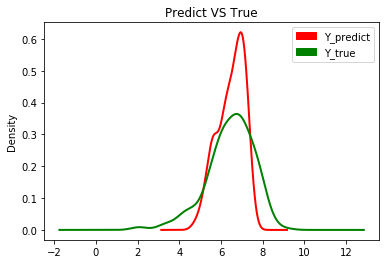

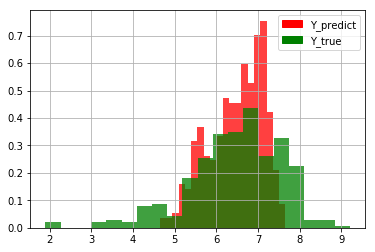

Mean imdb_score for Y_predict: 6.4742234103
Mean imdb_score for Y_true: 6.4455026455


In [216]:
res = pd.DataFrame()
res['Y_predict'] = Y_predict
res['imdb_score'] = Y_test
colors = ['red','green']
red_patch = mpatches.Patch(color = 'red',label='Y_predict')
green_patch = mpatches.Patch(color = 'green',label='Y_true')
patches = [red_patch,green_patch]
#Плотности распределений
res.Y_predict.plot(kind='kde',linewidth = 2,color=colors[0])
res.imdb_score.plot(kind='kde',linewidth = 2,color=colors[1])
plt.legend(handles=patches)
plt.title('Predict VS True')
plt.show()
#Гистограммы распределений
res.Y_predict.hist(normed = True,alpha=0.75,color=colors[0], bins = 20)
res.imdb_score.hist(normed = True,alpha=0.75,color=colors[1], bins = 20)
plt.legend(handles=patches)
plt.show()


print 'Mean imdb_score for Y_predict:',res.Y_predict.mean()
print 'Mean imdb_score for Y_true:',res.imdb_score.mean()


### Выводы: наша модель смогла объяснить только 0.39 от всей дисперсии распределения целевой переменной. Давайте попробуем использовать "классические" регроссоры из sklearn

In [3]:
std_scaler = StandardScaler()
train_data = std_scaler.fit_transform(movie_train_data)
X_train = train_data.transpose()[1:].transpose()
Y_train = movie_train_data.imdb_score.values

test_data = std_scaler.fit_transform(movie_test_data)
X_test = test_data.transpose()[1:].transpose()
Y_test = movie_test_data.imdb_score.values

pca = PCA(n_components=46)
X_train = pca.fit_transform(X_train,Y_train)
X_test = pca.transform(X_test)

## SVM

### LinearSVR

In [235]:
parameters = {
                'regr__loss': ['squared_epsilon_insensitive','epsilon_insensitive'],
                'regr__C': [0.1,0.01, 1, 2, 3, 5, 7, 10],
              }

pipeline = Pipeline([
    ('regr',  LinearSVR(random_state=0))
    ])
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='r2', verbose=True, n_jobs=-1)
grid_search.fit(X_train,Y_train)

print grid_search.best_score_
print '----------------------'
print grid_search.best_params_
print '----------------------'
print grid_search.best_estimator_
print '----------------------'
Y_predict = make_good_predict(grid_search.best_estimator_.predict(X_test))
print 'Mean absolute error:', mean_absolute_error(Y_test,Y_predict)
print 'Mean squared error:', mean_squared_error(Y_test,Y_predict)
print 'Explained variance score:', explained_variance_score(Y_test,Y_predict)
print 'R2 score:', r2_score(Y_test,Y_predict)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   13.4s finished


0.549792668974
----------------------
{'regr__loss': 'squared_epsilon_insensitive', 'regr__C': 1}
----------------------
Pipeline(memory=None,
     steps=[('regr', LinearSVR(C=1, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=1000, random_state=0, tol=0.0001, verbose=0))])
----------------------
Mean absolute error: 0.725617482536
Mean squared error: 0.908776361055
Explained variance score: 0.336274024077
R2 score: 0.336072237035


### SVR

In [236]:
parameters = {
                'regr__gamma': ['auto', 0.1, 0.01],
                'regr__C': [0.1,0.01, 1, 2, 3, 5, 7, 10],
              }

pipeline = Pipeline([
    ('regr',  SVR())
    ])
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='r2', verbose=True, n_jobs=-1)
grid_search.fit(X_train,Y_train)

print grid_search.best_score_
print '----------------------'
print grid_search.best_params_
print '----------------------'
print grid_search.best_estimator_
print '----------------------'
Y_predict = make_good_predict(grid_search.best_estimator_.predict(X_test))
print 'Mean absolute error:', mean_absolute_error(Y_test,Y_predict)
print 'Mean squared error:', mean_squared_error(Y_test,Y_predict)
print 'Explained variance score:', explained_variance_score(Y_test,Y_predict)
print 'R2 score:', r2_score(Y_test,Y_predict)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   58.8s finished


0.594239808086
----------------------
{'regr__C': 3, 'regr__gamma': 0.01}
----------------------
Pipeline(memory=None,
     steps=[('regr', SVR(C=3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])
----------------------
Mean absolute error: 0.688941677497
Mean squared error: 0.846537554384
Explained variance score: 0.386374700985
R2 score: 0.38154224864


### NuSVR 

In [237]:
parameters = {
                'regr__nu': [0.1, 0.01, 0.5, 1],
                'regr__C': [0.1,0.01, 1, 2, 3, 5, 7, 10],
                'regr__gamma' : ['auto', 0.1, 0.01],
              }

pipeline = Pipeline([
    ('regr',  NuSVR())
    ])
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='r2', verbose=True, n_jobs=-1)
grid_search.fit(X_train,Y_train)

print grid_search.best_score_
print '----------------------'
print grid_search.best_params_
print '----------------------'
print grid_search.best_estimator_
print '----------------------'
Y_predict = make_good_predict(grid_search.best_estimator_.predict(X_test))
print 'Mean absolute error:', mean_absolute_error(Y_test,Y_predict)
print 'Mean squared error:', mean_squared_error(Y_test,Y_predict)
print 'Explained variance score:', explained_variance_score(Y_test,Y_predict)
print 'R2 score:', r2_score(Y_test,Y_predict)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  3.1min finished


0.598519168651
----------------------
{'regr__C': 3, 'regr__nu': 0.5, 'regr__gamma': 0.01}
----------------------
Pipeline(memory=None,
     steps=[('regr', NuSVR(C=3, cache_size=200, coef0=0.0, degree=3, gamma=0.01, kernel='rbf',
   max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False))])
----------------------
Mean absolute error: 0.688658650286
Mean squared error: 0.852590127037
Explained variance score: 0.38154002136
R2 score: 0.377120400544


## neural_network

### MLPRegressor

In [240]:
parameters = {
                'regr__activation': ['identity', 'logistic', 'tanh', 'relu'],
                'regr__alpha': [0.0001,0.001, 0.01, 0.1, 1, 2, 5, 10],
                'regr__max_iter' : [1000],
                'regr__beta_1' : [0.9, 0.8],
                'regr__beta_2' : [0.999, 0.9],    
              }

pipeline = Pipeline([
    ('regr',  MLPRegressor(random_state  = 0, early_stopping = True, hidden_layer_sizes = (100, 100, 100,)))
    ])
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='r2', verbose=True, n_jobs=-1)
grid_search.fit(X_train,Y_train)

print grid_search.best_score_
print '----------------------'
print grid_search.best_params_
print '----------------------'
print grid_search.best_estimator_
print '----------------------'
Y_predict = make_good_predict(grid_search.best_estimator_.predict(X_test))
print 'Mean absolute error:', mean_absolute_error(Y_test,Y_predict)
print 'Mean squared error:', mean_squared_error(Y_test,Y_predict)
print 'Explained variance score:', explained_variance_score(Y_test,Y_predict)
print 'R2 score:', r2_score(Y_test,Y_predict)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:  5.2min finished


0.578849072979
----------------------
{'regr__alpha': 10, 'regr__activation': 'relu', 'regr__max_iter': 1000, 'regr__beta_1': 0.9, 'regr__beta_2': 0.9}
----------------------
Pipeline(memory=None,
     steps=[('regr', MLPRegressor(activation='relu', alpha=10, batch_size='auto', beta_1=0.9,
       beta_2=0.9, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))])
----------------------
Mean absolute error: 0.699878012103
Mean squared error: 0.859839924664
Explained variance score: 0.372123574752
R2 score: 0.371823891824


## linear_model

### BayesianRidge

In [246]:
parameters = {
                'regr__alpha_1': [1e-6, 1e-5, 1e-4],
                'regr__alpha_2': [1e-6, 1e-5, 1e-4],
                'regr__lambda_1': [1e-6, 1e-5, 1e-4],
                'regr__lambda_2': [1e-6, 1e-5, 1e-4],
              }

pipeline = Pipeline([
    ('regr',  BayesianRidge(n_iter = 1000))
    ])
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='r2', verbose=True, n_jobs=-1)
grid_search.fit(X_train,Y_train)

print grid_search.best_score_
print '----------------------'
print grid_search.best_params_
print '----------------------'
print grid_search.best_estimator_
print '----------------------'
Y_predict = make_good_predict(grid_search.best_estimator_.predict(X_test))
print 'Mean absolute error:', mean_absolute_error(Y_test,Y_predict)
print 'Mean squared error:', mean_squared_error(Y_test,Y_predict)
print 'Explained variance score:', explained_variance_score(Y_test,Y_predict)
print 'R2 score:', r2_score(Y_test,Y_predict)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:    2.9s


0.569335473618
----------------------
{'regr__lambda_1': 0.0001, 'regr__lambda_2': 1e-06, 'regr__alpha_2': 0.0001, 'regr__alpha_1': 1e-06}
----------------------
Pipeline(memory=None,
     steps=[('regr', BayesianRidge(alpha_1=1e-06, alpha_2=0.0001, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=0.0001, lambda_2=1e-06, n_iter=1000,
       normalize=False, tol=0.001, verbose=False))])
----------------------
Mean absolute error: 0.722408912824
Mean squared error: 0.904580395049
Explained variance score: 0.339404646075
R2 score: 0.33913769785


[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    4.4s finished


### ElasticNet

In [248]:
parameters = {
                'regr__alpha': [0.1, 0.5, 1, 2, 3, 5, 10],
                'regr__l1_ratio': [0.1, 0.5, 0.9, 0.01],
              }

pipeline = Pipeline([
    ('regr',  ElasticNet(max_iter = 1000, random_state  = 0))
    ])
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='r2', verbose=True, n_jobs=-1)
grid_search.fit(X_train,Y_train)

print grid_search.best_score_
print '----------------------'
print grid_search.best_params_
print '----------------------'
print grid_search.best_estimator_
print '----------------------'
Y_predict = make_good_predict(grid_search.best_estimator_.predict(X_test))
print 'Mean absolute error:', mean_absolute_error(Y_test,Y_predict)
print 'Mean squared error:', mean_squared_error(Y_test,Y_predict)
print 'Explained variance score:', explained_variance_score(Y_test,Y_predict)
print 'R2 score:', r2_score(Y_test,Y_predict)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
0.56897723833
----------------------
{'regr__alpha': 0.1, 'regr__l1_ratio': 0.01}
----------------------
Pipeline(memory=None,
     steps=[('regr', ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.01,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False))])
----------------------
Mean absolute error: 0.705867214271
Mean squared error: 0.878777208917
Explained variance score: 0.358255765427
R2 score: 0.357988817201


[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    2.4s finished


### HuberRegressor

In [250]:
parameters = {
                'regr__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 2, 5],
                'regr__epsilon': [1.1, 1.35, 1.7, 2, 4, 7],
              }

pipeline = Pipeline([
    ('regr',  HuberRegressor(max_iter = 1000))
    ])
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='r2', verbose=True, n_jobs=-1)
grid_search.fit(X_train,Y_train)

print grid_search.best_score_
print '----------------------'
print grid_search.best_params_
print '----------------------'
print grid_search.best_estimator_
print '----------------------'
Y_predict = make_good_predict(grid_search.best_estimator_.predict(X_test))
print 'Mean absolute error:', mean_absolute_error(Y_test,Y_predict)
print 'Mean squared error:', mean_squared_error(Y_test,Y_predict)
print 'Explained variance score:', explained_variance_score(Y_test,Y_predict)
print 'R2 score:', r2_score(Y_test,Y_predict)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    6.1s finished


0.568850761637
----------------------
{'regr__alpha': 5, 'regr__epsilon': 7}
----------------------
Pipeline(memory=None,
     steps=[('regr', HuberRegressor(alpha=5, epsilon=7, fit_intercept=True, max_iter=1000,
        tol=1e-05, warm_start=False))])
----------------------
Mean absolute error: 0.724931596829
Mean squared error: 0.908815887009
Explained variance score: 0.336310818136
R2 score: 0.336043360428


### LinearRegression

In [252]:
parameters = {

              }

pipeline = Pipeline([
    ('regr',  LinearRegression(n_jobs = -1))
    ])
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='r2', verbose=True, n_jobs=-1)
grid_search.fit(X_train,Y_train)

print grid_search.best_score_
print '----------------------'
print grid_search.best_params_
print '----------------------'
print grid_search.best_estimator_
print '----------------------'
Y_predict = make_good_predict(grid_search.best_estimator_.predict(X_test))
print 'Mean absolute error:', mean_absolute_error(Y_test,Y_predict)
print 'Mean squared error:', mean_squared_error(Y_test,Y_predict)
print 'Explained variance score:', explained_variance_score(Y_test,Y_predict)
print 'R2 score:', r2_score(Y_test,Y_predict)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
-4.81794178805e+25
----------------------
{}
----------------------
Pipeline(memory=None,
     steps=[('regr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False))])
----------------------
Mean absolute error: 3.60819022457
Mean squared error: 14.4838573316
Explained variance score: -1.05847579995
R2 score: -9.58151973284


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished


### SGDRegressor

In [257]:
parameters = {
                'regr__loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
                'regr__penalty': ['l2', 'l1', 'elasticnet'],
              }

pipeline = Pipeline([
    ('regr',  SGDRegressor(max_iter = 1000, random_state = 0, power_t = 0.01))
    ])
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='r2', verbose=True, n_jobs=-1)
grid_search.fit(X_train,Y_train)

print grid_search.best_score_
print '----------------------'
print grid_search.best_params_
print '----------------------'
print grid_search.best_estimator_
print '----------------------'
Y_predict = make_good_predict(grid_search.best_estimator_.predict(X_test))
print 'Mean absolute error:', mean_absolute_error(Y_test,Y_predict)
print 'Mean squared error:', mean_squared_error(Y_test,Y_predict)
print 'Explained variance score:', explained_variance_score(Y_test,Y_predict)
print 'R2 score:', r2_score(Y_test,Y_predict)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   28.0s finished


0.556229126009
----------------------
{'regr__loss': 'huber', 'regr__penalty': 'l2'}
----------------------
Pipeline(memory=None,
     steps=[('regr', SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='huber', max_iter=1000, n_iter=None, penalty='l2',
       power_t=0.01, random_state=0, shuffle=True, tol=None, verbose=0,
       warm_start=False))])
----------------------
Mean absolute error: 0.706317015578
Mean squared error: 0.90224160182
Explained variance score: 0.343567879964
R2 score: 0.340846357783


## ensemble 

### AdaBoostRegressor

In [258]:
parameters = {
                'regr__loss': ['linear', 'square', 'exponential'],
                'regr__n_estimators': [10, 50, 100, 200, 500],
              }

pipeline = Pipeline([
    ('regr',  AdaBoostRegressor(random_state = 0))
    ])
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='r2', verbose=True, n_jobs=-1)
grid_search.fit(X_train,Y_train)

print grid_search.best_score_
print '----------------------'
print grid_search.best_params_
print '----------------------'
print grid_search.best_estimator_
print '----------------------'
Y_predict = make_good_predict(grid_search.best_estimator_.predict(X_test))
print 'Mean absolute error:', mean_absolute_error(Y_test,Y_predict)
print 'Mean squared error:', mean_squared_error(Y_test,Y_predict)
print 'Explained variance score:', explained_variance_score(Y_test,Y_predict)
print 'R2 score:', r2_score(Y_test,Y_predict)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   54.3s finished


0.481317247448
----------------------
{'regr__loss': 'linear', 'regr__n_estimators': 200}
----------------------
Pipeline(memory=None,
     steps=[('regr', AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=200, random_state=0))])
----------------------
Mean absolute error: 0.713237203059
Mean squared error: 0.883160994368
Explained variance score: 0.370114037945
R2 score: 0.354786140511


### BaggingRegressor

In [261]:
parameters = {
                'regr__bootstrap_features': [True, False],
                'regr__n_estimators': [10, 20, 5, 30, 50, 100, 200, 500],
                'regr__max_features': [40, 46 ],
                'regr__max_samples': [40, 46],
              }

pipeline = Pipeline([
    ('regr',  BaggingRegressor(random_state = 0, n_jobs = -1))
    ])
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='r2', verbose=True, n_jobs=-1)
grid_search.fit(X_train,Y_train)

print grid_search.best_score_
print '----------------------'
print grid_search.best_params_
print '----------------------'
print grid_search.best_estimator_
print '----------------------'
Y_predict = make_good_predict(grid_search.best_estimator_.predict(X_test))
print 'Mean absolute error:', mean_absolute_error(Y_test,Y_predict)
print 'Mean squared error:', mean_squared_error(Y_test,Y_predict)
print 'Explained variance score:', explained_variance_score(Y_test,Y_predict)
print 'R2 score:', r2_score(Y_test,Y_predict)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  1.2min finished


0.378930780112
----------------------
{'regr__n_estimators': 500, 'regr__bootstrap_features': False, 'regr__max_features': 46, 'regr__max_samples': 46}
----------------------
Pipeline(memory=None,
     steps=[('regr', BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=46, max_samples=46,
         n_estimators=500, n_jobs=-1, oob_score=False, random_state=0,
         verbose=0, warm_start=False))])
----------------------
Mean absolute error: 0.724441215324
Mean squared error: 0.997615354505
Explained variance score: 0.271216595081
R2 score: 0.271168838672


### GradientBoostingRegressor

In [15]:
parameters = {
                'regr__loss': ['ls', 'lad', 'huber', 'quantile'],
                'regr__n_estimators': [200],
                'regr__max_features': [5, 10],
                'regr__max_depth': [3, 5],     
              }

pipeline = Pipeline([
    ('regr',  GradientBoostingRegressor(random_state = 0))
    ])
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='r2', verbose=True, n_jobs=-1)
grid_search.fit(X_train,Y_train)

print grid_search.best_score_
print '----------------------'
print grid_search.best_params_
print '----------------------'
print grid_search.best_estimator_
print '----------------------'
Y_predict = make_good_predict(grid_search.best_estimator_.predict(X_test))
print 'Mean absolute error:', mean_absolute_error(Y_test,Y_predict)
print 'Mean squared error:', mean_squared_error(Y_test,Y_predict)
print 'Explained variance score:', explained_variance_score(Y_test,Y_predict)
print 'R2 score:', r2_score(Y_test,Y_predict)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   25.4s finished


0.577747756039
----------------------
{'regr__loss': 'ls', 'regr__max_features': 10, 'regr__n_estimators': 200, 'regr__max_depth': 5}
----------------------
Pipeline(memory=None,
     steps=[('regr', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=10,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False))])
----------------------
Mean absolute error: 0.701122435215
Mean squared error: 0.87782226367
Explained variance score: 0.35892496484
R2 score: 0.35868647472


### RandomForestRegressor

In [14]:
parameters = {
                'regr__min_samples_split': [2, 5, 3, 10],
                'regr__n_estimators': [10, 20, 5, 50, 100],
                'regr__max_features': [5, 10, 20, 30, 46],
                'regr__max_depth': [5, 10, 2, None],
                'regr__criterion': ['mse', 'mae'],
                'regr__bootstrap': [True, False],
     
    
              }

pipeline = Pipeline([
    ('regr',  RandomForestRegressor(random_state = 0, n_jobs = -1))
    ])
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='r2', verbose=True, n_jobs=-1)
grid_search.fit(X_train,Y_train)

print grid_search.best_score_
print '----------------------'
print grid_search.best_params_
print '----------------------'
print grid_search.best_estimator_
print '----------------------'
Y_predict = make_good_predict(grid_search.best_estimator_.predict(X_test))
print 'Mean absolute error:', mean_absolute_error(Y_test,Y_predict)
print 'Mean squared error:', mean_squared_error(Y_test,Y_predict)
print 'Explained variance score:', explained_variance_score(Y_test,Y_predict)
print 'R2 score:', r2_score(Y_test,Y_predict)

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 95.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 182.5min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 189.1min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 314.8min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed: 604.6min finished


0.560185408657
----------------------
{'regr__criterion': 'mse', 'regr__min_samples_split': 3, 'regr__n_estimators': 100, 'regr__max_features': 20, 'regr__max_depth': None, 'regr__bootstrap': True}
----------------------
Pipeline(memory=None,
     steps=[('regr', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=20, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False))])
----------------------
Mean absolute error: 0.657018704263
Mean squared error: 0.830121591279
Explained variance score: 0.39398879877
R2 score: 0.393535313301


### ExtraTreesRegressor

In [13]:
parameters = {
                'regr__min_samples_split': [2, 5, 3, 10],
                'regr__n_estimators': [15, 5, 50],
                'regr__max_features': [5, 10, 20, 30, 46],
                'regr__max_depth': [5, 10, 2, None],
                'regr__criterion': ['mse', 'mae'],
                'regr__bootstrap': [True, False],
     
    
              }

pipeline = Pipeline([
    ('regr',  ExtraTreesRegressor(random_state = 0, n_jobs = -1))
    ])
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='r2', verbose=True, n_jobs=-1)
grid_search.fit(X_train,Y_train)

print grid_search.best_score_
print '----------------------'
print grid_search.best_params_
print '----------------------'
print grid_search.best_estimator_
print '----------------------'
Y_predict = make_good_predict(grid_search.best_estimator_.predict(X_test))
print 'Mean absolute error:', mean_absolute_error(Y_test,Y_predict)
print 'Mean squared error:', mean_squared_error(Y_test,Y_predict)
print 'Explained variance score:', explained_variance_score(Y_test,Y_predict)
print 'R2 score:', r2_score(Y_test,Y_predict)

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 54.5min finished


0.560178533075
----------------------
{'regr__criterion': 'mse', 'regr__min_samples_split': 10, 'regr__n_estimators': 50, 'regr__max_features': 46, 'regr__max_depth': None, 'regr__bootstrap': False}
----------------------
Pipeline(memory=None,
     steps=[('regr', ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=46, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1,
          min_samples_split=10, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=-1, oob_score=False, random_state=0,
          verbose=0, warm_start=False))])
----------------------
Mean absolute error: 0.639134095532
Mean squared error: 0.786809693999
Explained variance score: 0.426389804267
R2 score: 0.42517782988


In [15]:
parameters = {
                'regr__min_samples_split': [10,11,9,8,12],
                'regr__n_estimators': [50,60,70,80,90,100,110,120],
                'regr__max_features': [46],
                'regr__max_depth': [None],
                'regr__criterion': ['mse'],
                'regr__bootstrap': [False],
     
    
              }

pipeline = Pipeline([
    ('regr',  ExtraTreesRegressor(random_state = 0, n_jobs = -1))
    ])
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='r2', verbose=True, n_jobs=-1)
grid_search.fit(X_train,Y_train)

print grid_search.best_score_
print '----------------------'
print grid_search.best_params_
print '----------------------'
print grid_search.best_estimator_
print '----------------------'
Y_predict = make_good_predict(grid_search.best_estimator_.predict(X_test))
print 'Mean absolute error:', mean_absolute_error(Y_test,Y_predict)
print 'Mean squared error:', mean_squared_error(Y_test,Y_predict)
print 'Explained variance score:', explained_variance_score(Y_test,Y_predict)
print 'R2 score:', r2_score(Y_test,Y_predict)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.3min finished


0.566041853348
----------------------
{'regr__criterion': 'mse', 'regr__min_samples_split': 9, 'regr__n_estimators': 120, 'regr__max_features': 46, 'regr__max_depth': None, 'regr__bootstrap': False}
----------------------
Pipeline(memory=None,
     steps=[('regr', ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=46, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=9,
          min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=-1,
          oob_score=False, random_state=0, verbose=0, warm_start=False))])
----------------------
Mean absolute error: 0.644831714841
Mean squared error: 0.804936648158
Explained variance score: 0.412913440498
R2 score: 0.411934760804


### Лучше всего себя показал ExtraTreeRegressor

In [6]:
parameters = {
                'regr__min_samples_split': [10],
                'regr__n_estimators': [50],
                'regr__max_features': [46],
                'regr__max_depth': [None],
                'regr__criterion': ['mse'],
                'regr__bootstrap': [False],
     
    
              }

pipeline = Pipeline([
    ('regr',  ExtraTreesRegressor(random_state = 0, n_jobs = -1))
    ])
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='r2', verbose=True, n_jobs=-1)
grid_search.fit(X_train,Y_train)

print grid_search.best_score_
print '----------------------'
print grid_search.best_params_
print '----------------------'
print grid_search.best_estimator_
print '----------------------'
Y_predict = make_good_predict(grid_search.best_estimator_.predict(X_test))
print 'Mean absolute error:', mean_absolute_error(Y_test,Y_predict)
print 'Mean squared error:', mean_squared_error(Y_test,Y_predict)
print 'Explained variance score:', explained_variance_score(Y_test,Y_predict)
print 'R2 score:', r2_score(Y_test,Y_predict)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s finished


0.560178533075
----------------------
{'regr__criterion': 'mse', 'regr__min_samples_split': 10, 'regr__n_estimators': 50, 'regr__max_features': 46, 'regr__max_depth': None, 'regr__bootstrap': False}
----------------------
Pipeline(memory=None,
     steps=[('regr', ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=46, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1,
          min_samples_split=10, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=-1, oob_score=False, random_state=0,
          verbose=0, warm_start=False))])
----------------------
Mean absolute error: 0.639134095532
Mean squared error: 0.786809693999
Explained variance score: 0.426389804267
R2 score: 0.42517782988


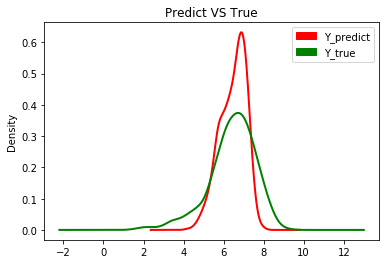

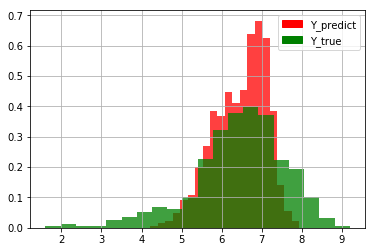

Mean imdb_score for Y_predict: 6.46662171584
Mean imdb_score for Y_true: 6.42589167768


In [7]:
res = pd.DataFrame()
res['Y_predict'] = Y_predict
res['imdb_score'] = Y_test
colors = ['red','green']
red_patch = mpatches.Patch(color = 'red',label='Y_predict')
green_patch = mpatches.Patch(color = 'green',label='Y_true')
patches = [red_patch,green_patch]
#Плотности распределений
res.Y_predict.plot(kind='kde',linewidth = 2,color=colors[0])
res.imdb_score.plot(kind='kde',linewidth = 2,color=colors[1])
plt.legend(handles=patches)
plt.title('Predict VS True')
plt.show()
#Гистограммы распределений
res.Y_predict.hist(normed = True,alpha=0.75,color=colors[0], bins = 20)
res.imdb_score.hist(normed = True,alpha=0.75,color=colors[1], bins = 20)
plt.legend(handles=patches)
plt.show()


print 'Mean imdb_score for Y_predict:',res.Y_predict.mean()
print 'Mean imdb_score for Y_true:',res.imdb_score.mean()


## Выводы

### 1)В ходе исследования нам удалось создать модель, объясняющую 42% дисперсии распределения оценок фильмов на IMDB.
### 2)Мы намерено не использовали признаки явно коррелирующие с целевой переменной, пытаясь достичь наилучешего результата на основе начальных данных.
### 3)Для достижения лучшего качества необходимо увеличить обучающую выборку. Это поможет побороть  переобучение нашей модели.
### 4)Возможно стоит отказаться от фильмов вышедших более 15 лет назад, чтобы следовать трендам текущего времени.
### 5)Также возможно использование нелинейного ядра признаков поможет увеличить качество.
### 6)Добавление признаков, основанных на конкретных актерах, возможно повлияет на качество в лучшую сторону.
### 7)В целом имея больший объем данных, вполне реально объяснить до 80% дисперсии распределения оценок.